# When Do Different Types of Collisions Occur?

Understanding when the different types of collisions occur can help determine the cause of collisions and suggest possible mitigations to reduce collisions, injuries, and deaths.

### Definitions
- __Collision:__ A motor vehicle collision involving injuries, deaths, or a significant amount of property damage (~> $1000) reported on a New York State form, MV104-AN
- __Serious Collision:__ A collision where at least one person is injured or killed
- __Non-Motorist:__ A pedestrian or cyclist (not the driver or passenger of a motor vehicle)


### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
- Collision data was processed by running `process_raw.data.py` which saves processed data to local directory specified in `process_raw.data.py` script
- Traffic index was created in 2-profiling-preparing-traffic-data.ipynb notebook using Metropolitan Transit Authority (MTA) Bridge and Tunnel toll data (https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga/about_data)

In [1]:
from datetime import datetime
import os.path
import matplotlib as mpl
import pandas as pd
import src.strings

from src.constants import DAY_OF_WEEK_MAP, MONTHS_MAP, SEASONS
import src.utils
from src import visualizations as viz

# Parameters 

In [2]:
PROCESSED_CRASH_DATA = "data/processed/crashes.pkl"
MTA_CROSSINGS_DATA = "data/processed/traffic_index.pkl"
IMG_DIR = "output"
ANALYSIS_START_DATE = datetime(year=2013, month=1, day=1)
ANALYSIS_END_DATE = datetime(year=2024, month=1, day=1)
MILLION = 1000000

# Helper Functions

In [3]:
def make_collision_groupby(df, groupby_col, divisor):
    """Returns a pd.DataFrame of groupby aggregates for serious collisions
    and non-motorist collisions"""
    ret_df = pd.DataFrame()
    ret_df["Serious Collisions"] = (
        df.groupby(by=groupby_col, observed=False)["serious"].sum() / divisor
    )
    ret_df["Non-Motorist Serious"] = (
        df.groupby(by=groupby_col, observed=False)["non-motorist"].sum() / divisor
    )
    return ret_df


def normalize_groupby(
    crash_groupby, activity_groupby: pd.Series, columns: list, keep=False
):
    """Normalize a groupby by an input groupby"""
    ret_df = crash_groupby.copy()
    ret_df["Activity"] = activity_groupby
    keep_cols = []
    for col in columns:
        norm_col = f"Normalized {col}"
        keep_cols.append(norm_col)
        ret_df[norm_col] = ret_df[col] / ret_df["Activity"]
    if keep:
        return ret_df
    return ret_df[keep_cols]


def get_normalized_crosstab_min_max(
    df,
    df_norm,
    col,
    categories,
    aggfunc_norm=None,
    agg_col=None,
    divisor=None,
    norm_divisor=None,
):
    """Returns the absolute min and absolute max values of normalized weekly crosstabs across all categories.
    Used to ensure that different heatmaps have the same scale."""
    max_val = float("-inf")
    min_val = float("inf")
    for cat in categories:
        mask = df[col].isin([cat])
        idx = df.loc[mask, "datetime"].dt.dayofweek
        cols = df.loc[mask, "datetime"].dt.hour
        ct = pd.crosstab(index=idx, columns=cols)

        mask_norm = df_norm[col].isin([cat])
        idx_norm = df_norm.loc[mask_norm, "datetime"].dt.dayofweek
        cols_norm = df_norm.loc[mask_norm, "datetime"].dt.hour
        ct_norm = pd.crosstab(
            index=idx_norm,
            columns=cols_norm,
            aggfunc=aggfunc_norm,
            values=df_norm.loc[mask_norm, agg_col],
        )

        if norm_divisor:
            ct_norm /= norm_divisor

        normalized_ct = ct / ct_norm

        min_val = min(min_val, min(normalized_ct.min()))  # ct.min() returns pd.Series
        max_val = max(max_val, max(normalized_ct.max()))
    if divisor:
        min_val /= divisor
        max_val /= divisor
    return min_val, max_val

# Data Preparation

__Loading datasets__

In [4]:
crashes = pd.read_pickle(PROCESSED_CRASH_DATA)
mta_crossings = pd.read_pickle(MTA_CROSSINGS_DATA)

__Selecting date range__

In [5]:
crashes = crashes[
    crashes["datetime"].between(
        ANALYSIS_START_DATE, ANALYSIS_END_DATE, inclusive="left"
    )
]

Dropping MTA Crossings data from 2017 which had notable gaps as documented in 2-profiling-preparing-traffic-data.ipynb

In [6]:
mta_crossings = mta_crossings[
    mta_crossings["datetime"].between(
        ANALYSIS_START_DATE, ANALYSIS_END_DATE, inclusive="left"
    )
]
mta_crossings = mta_crossings[mta_crossings["datetime"].dt.year != 2017]

__Creating dataframes / views that will be used for analysis__

Analysis will focus on collisions resulting in injuries or deaths. The reporting of collisions without injuries or deaths is less consistent

In [7]:
serious = crashes[crashes["serious"]].copy()

Adding extra columns

In [8]:
serious["Pedestrians and Cyclists Injured"] = (
    serious["PEDESTRIAN INJURED"] + serious["CYCLIST INJURED"]
)

serious["Pedestrians and Cyclists Killed"] = (
    serious["PEDESTRIAN KILLED"] + serious["CYCLIST KILLED"]
)
serious = serious.rename(columns={"INJURED": "Total Injured", "KILLED": "Total Killed"})

View for collisions involving pedestrians and cyclists

In [9]:
non_motorist = serious[serious["non-motorist"]]

Creating views of crashes that exclude 2017 data to use with MTA crossings

In [10]:
serious_ex_2017 = serious[serious["datetime"].dt.year != 2017]
non_motorist_ex_2017 = non_motorist[non_motorist["datetime"].dt.year != 2017]

__Adding season attribute to MTA crossings based on datetime__

In [11]:
mta_crossings["season"] = mta_crossings["datetime"].apply(src.utils.date_to_season)

__Calculating time-related values for scaling values__

In [12]:
time_range = (
    crashes["datetime"].max() - crashes["datetime"].min()
)  # Pandas Timedelta object
total_days = time_range.round("1d").days
total_years = total_days / 365.25
total_weeks = total_days / 7
total_weeks_ex_17 = (total_days - 365) / 7

# What are overall trends in collisions over the last few years? 

## Serious Collisions
- From 2013 to 2019 there were:
    - Between 37k and 46k collisions per year that injured or killed at least one person, an __average of ~100 to ~120 a day__
    - Between 14k and 16k collisions per year that injured or killed at least one pedestrians or cyclist, an __average of ~38 to ~44 a day__
- Serious collisions trended upwards from 2013 to 2019 while collisions with pedestrians and cyclists was approximately flat
- Serious collisions and collisions with pedestrians and cyclists dropped sharply in 2020 (presumably due to COVID) but have been trending upwards since then

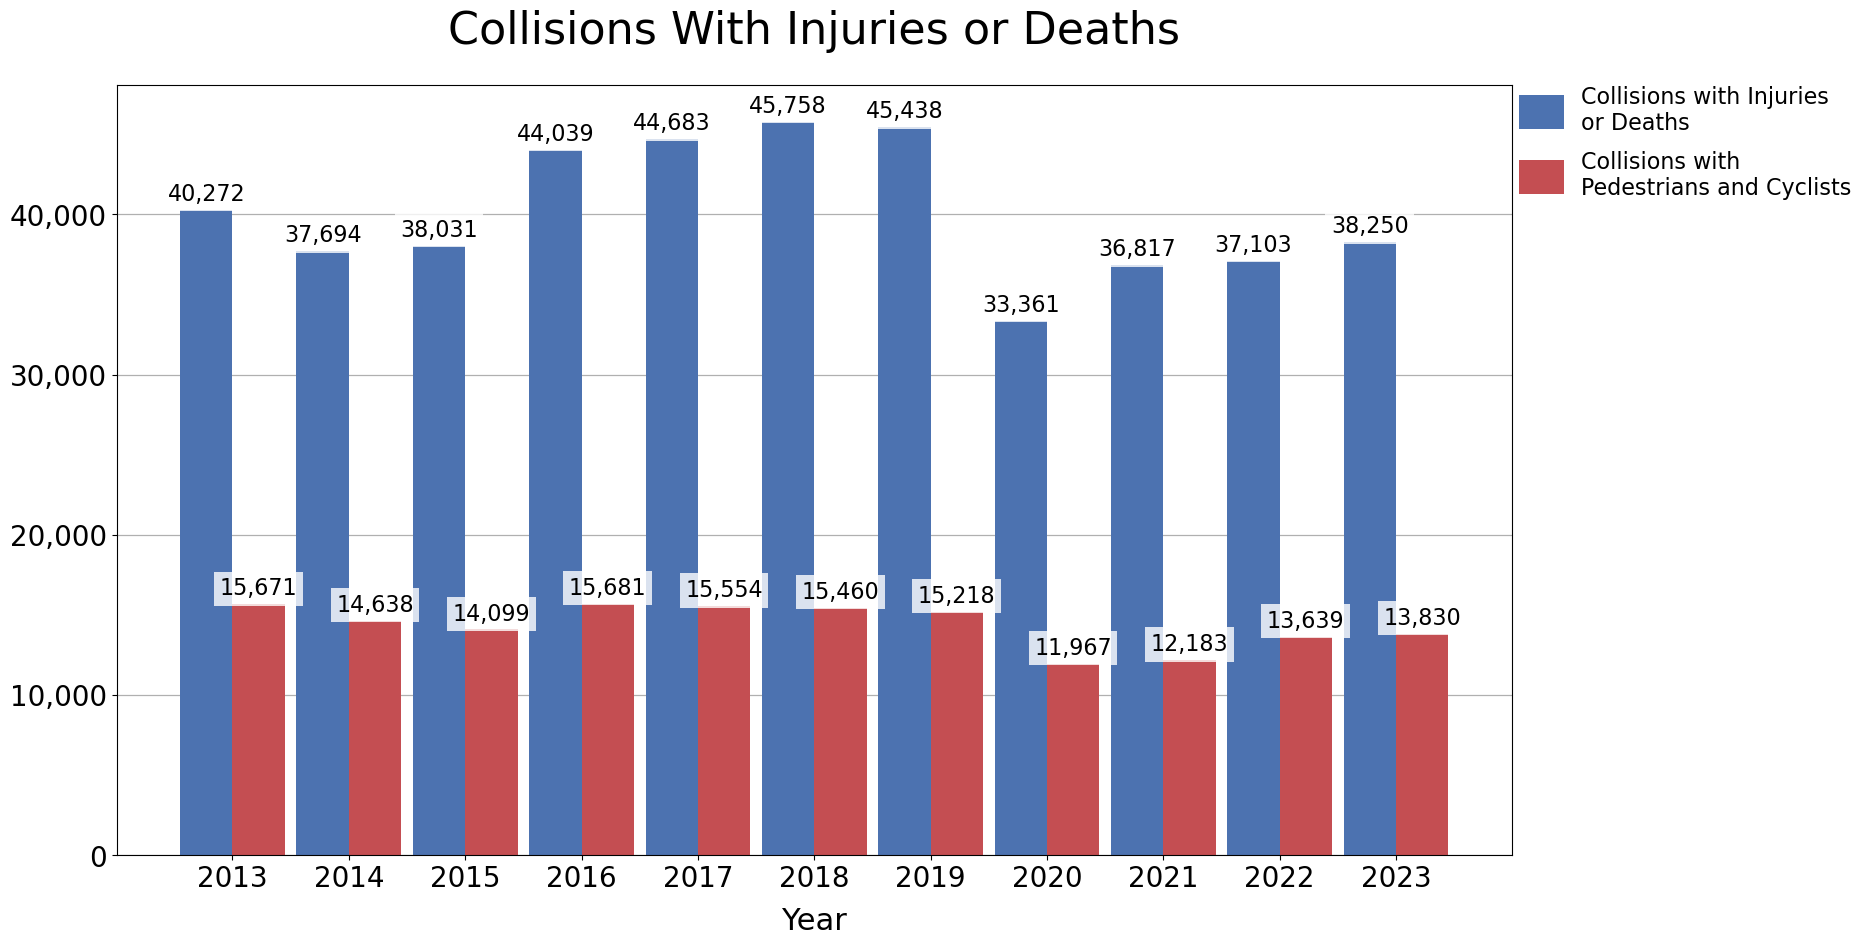

In [13]:
year_groupby = make_collision_groupby(serious, serious["datetime"].dt.year, divisor=1)
year_labels = {
    "title": "Collisions With Injuries or Deaths",
    "y_label": "",
    "x_label": "Year",
}
groups = [
    "Collisions with Injuries or Deaths",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    year_groupby,
    **year_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    legend_handleheight=2.0,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "yearly_collisions.png"),
)

Normalizing collisions by millions of MTA bridge and tunnel crossings, a proxy for vehicle activity

In [14]:
annual_mta_crossings = (
    mta_crossings.groupby(by=mta_crossings["datetime"].dt.year)["Sum Vehicles"].sum()
    / MILLION
)
year_ex_2017 = year_groupby[year_groupby.index != 2017]
cols_to_use = ["Serious Collisions", "Non-Motorist Serious"]
year_ex_2017 = normalize_groupby(year_ex_2017, annual_mta_crossings, cols_to_use)

## Normalized Serious Collisions

- The number of serious collisions and collisions involving pedestrians and cyclists relative to driving activity appears to be trending downwards. This could indicate that efforts to improve road safety are working
- These results may also reflect changing driving patterns with traffic being shifted to the major roadways controlled by the MTA

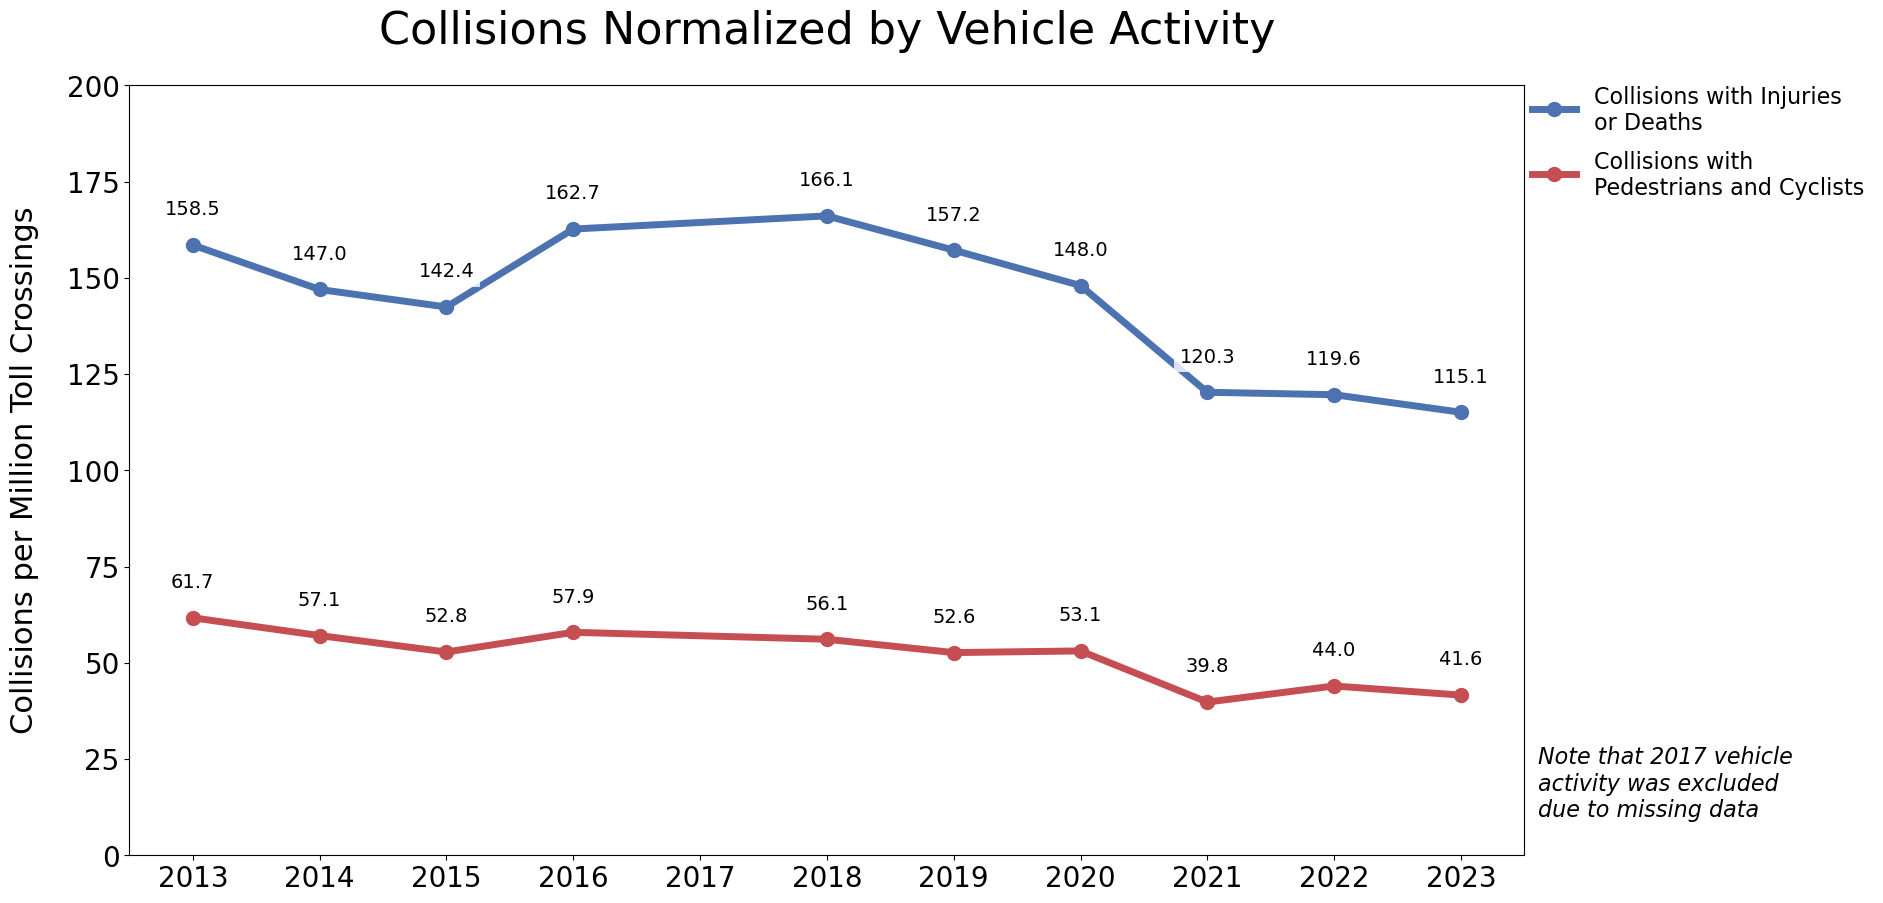

In [15]:
x = year_ex_2017.index.values
data_to_plot = [
    (x, year_ex_2017["Normalized Serious Collisions"]),
    (x, year_ex_2017["Normalized Non-Motorist Serious"]),
]

title = "Collisions Normalized by Vehicle Activity"
ylabel = "Collisions per Million Toll Crossings"
groups = [
    "Collisions with Injuries or Deaths",
    "Collisions with Pedestrians and Cyclists",
]
note = "Note that 2017 vehicle\nactivity was excluded\ndue to missing data"

viz.make_line_chart(
    data_to_plot,
    title=title,
    y_label=ylabel,
    ylabel_rotation="vertical",
    ylabel_pad=20,
    y_lim=[0, 200],
    set_major_tick_x=mpl.ticker.MultipleLocator(1),
    colors=viz.CYCLE_COLORS,
    annotate=True,
    vert_offset=30,
    annotate_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    legend_labels=src.strings.add_line_breaks(groups),
    text=[1.01, 0.05, note],
    text_fontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "yearly_collisions_norm.png"),
)

## Injuries and Deaths

#### Overall Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 51k and 62k injuries per year, an __average of ~140 to ~170 a day__
    - __Between 230 and 300 people killed in collisions each year__
- Total injuries trended upwards from 2013 to 2019
- Total injuries in 2021-2023 were ~15% lower than 2018 / 2019 levels
- Fatalities from 2021-2023 were elevated

#### Pedestrian / Cyclist (Non-Motorist) Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 14k and 16k pedestrians and cyclists injured per year, an __average of ~38 to ~44 a day__
    - __Between 130 and 190 pedestrians and cyclists killed in collisions each year__
- Total pedestrian and cyclist injuries were approximately flat from 2013 to 2019
- Pedestrian and cyclist injuries dropped in 2020 but have been trending upwards

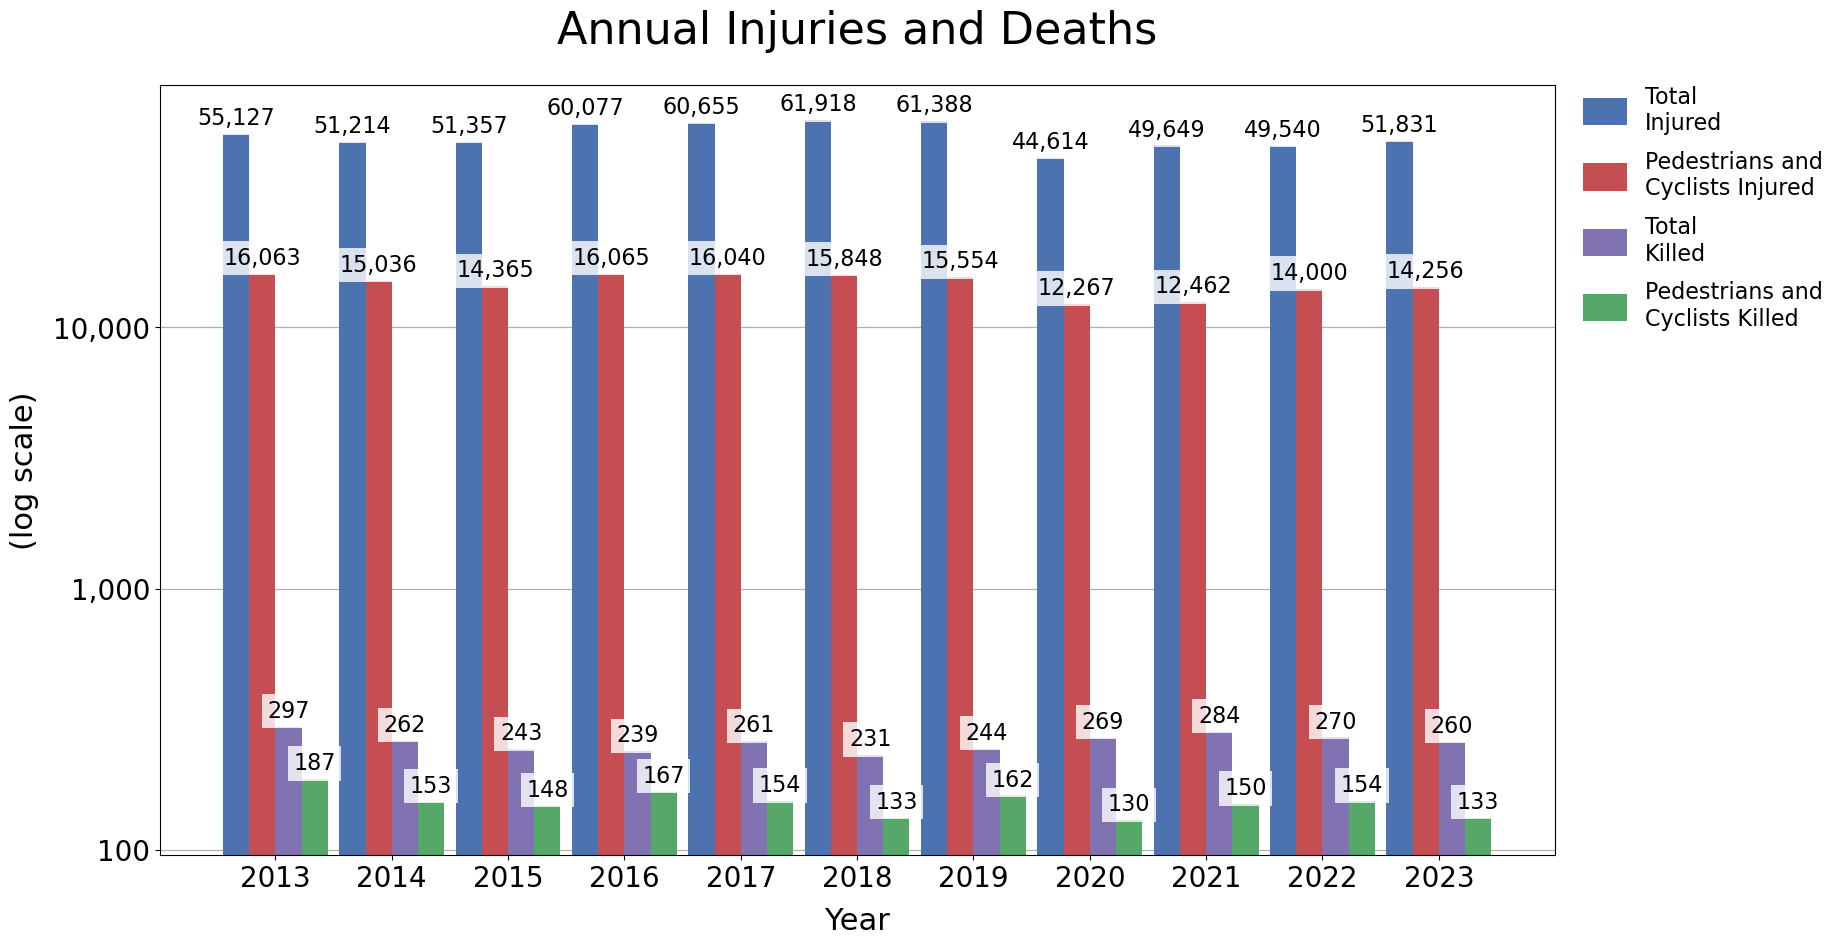

In [16]:
loss_fields = [
    "Total Injured",
    "Pedestrians and Cyclists Injured",
    "Total Killed",
    "Pedestrians and Cyclists Killed",
]
losses = serious.groupby(by=serious["datetime"].dt.year)[loss_fields].sum()
losses_labels = {
    "title": "Annual Injuries and Deaths",
    "y_label": "(log scale)",
    "x_label": "Year",
}
groups = [
    "Total Injured",
    "Pedestrians and Cyclists Injured",
    "Total Killed",
    "Pedestrians and Cyclists Killed",
]
viz.make_grouped_bar_chart(
    losses,
    **losses_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    logscale=True,
    minor_ticks_off=True,
    ylabel_rotation="vertical",
    ylabel_pad=10,
    legend_bbox=(1.06, 0.9),
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "yearly_injuries_deaths.png"),
)

Normalizing injuries and deaths by millions of MTA bridge and tunnel crossings, a proxy for vehicle activity

In [17]:
losses_ex_2017 = losses[losses.index != 2017]
losses_ex_2017_norm = normalize_groupby(
    losses_ex_2017, annual_mta_crossings, loss_fields
)

## Normalized Injuries and Deaths
- Normalized injuries have been trending downwards since 2020
- Pedestrians and cyclist injuries have also been trending downwards since 2020 adjusting for vehicle activity. This however may just reflect reduced pedestrian and cycling traffic
- Deaths adjusted for vehicle activity spiked in 2020 and have returned to the recent historical average
- Pedestrians and cyclist deaths appear to be tranding downwards since 2020 but once again may just reflect reduced pedestrian and cycling traffic

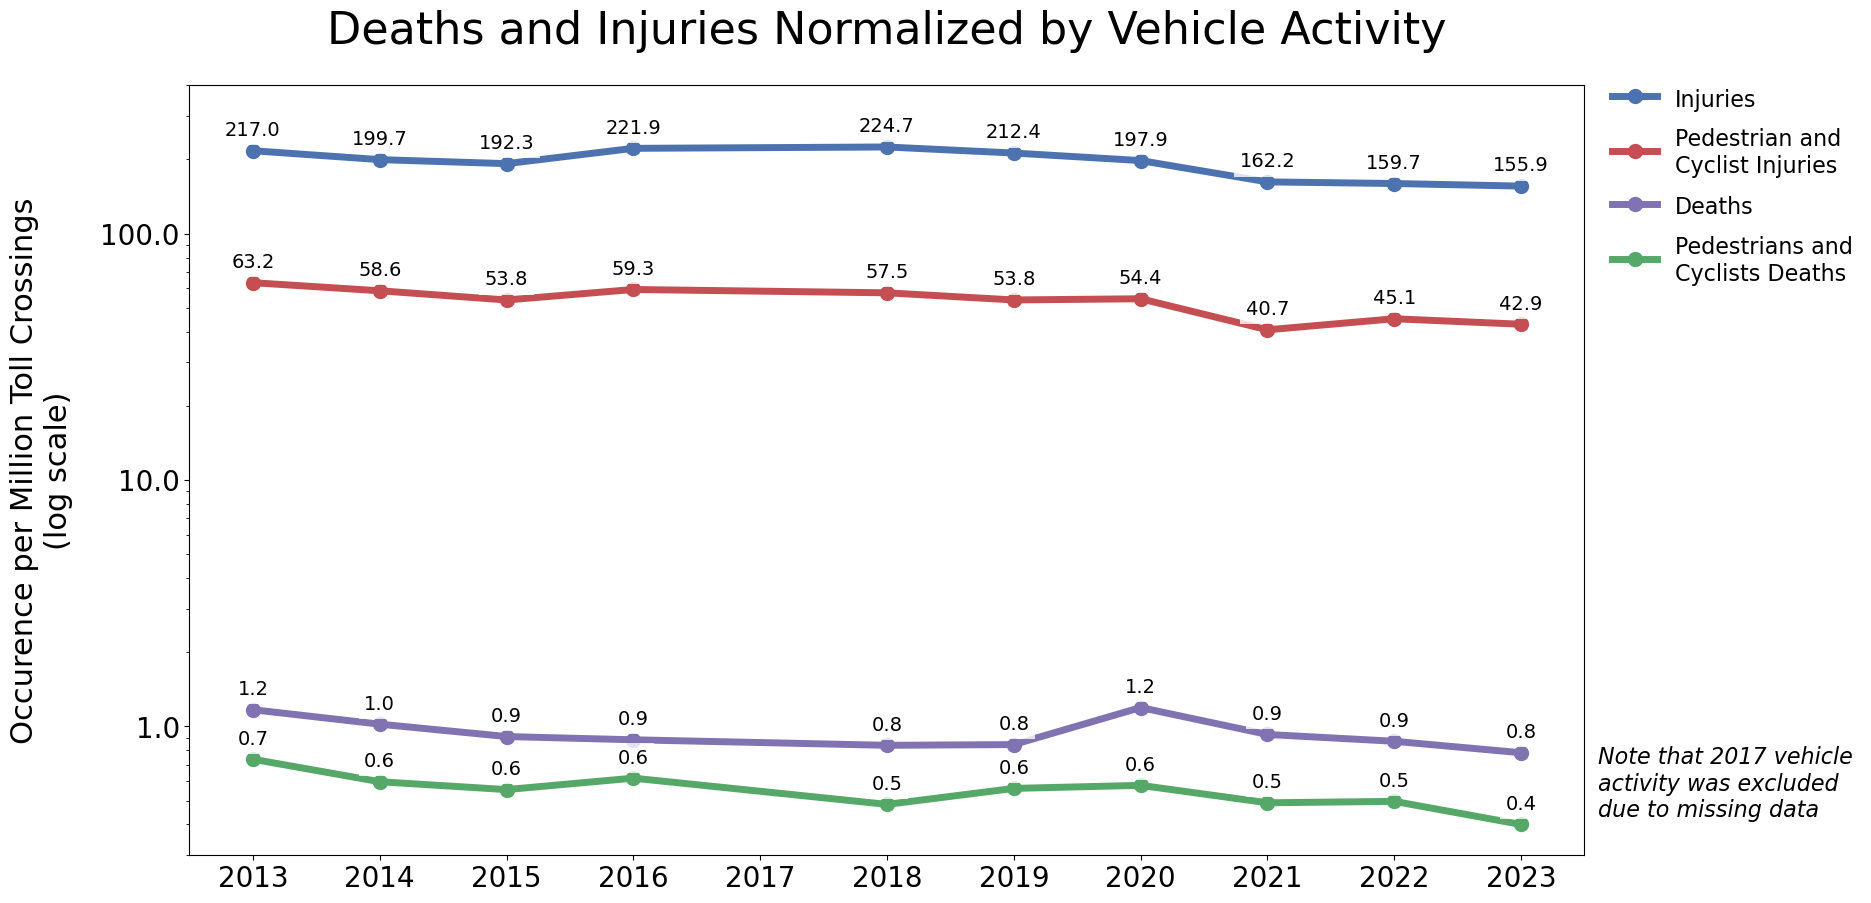

In [18]:
x = losses_ex_2017_norm.index.values
data_to_plot = [
    (x, losses_ex_2017_norm["Normalized Total Injured"]),
    (x, losses_ex_2017_norm["Normalized Pedestrians and Cyclists Injured"]),
    (x, losses_ex_2017_norm["Normalized Total Killed"]),
    (x, losses_ex_2017_norm["Normalized Pedestrians and Cyclists Killed"]),
]

title = "Deaths and Injuries Normalized by Vehicle Activity"
ylabel = "Occurence per Million Toll Crossings\n(log scale)"
groups = [
    "Injuries",
    "Pedestrian and Cyclist Injuries",
    "Deaths",
    "Pedestrians and Cyclists Deaths",
]
note = "Note that 2017 vehicle\nactivity was excluded\ndue to missing data"

viz.make_line_chart(
    data_to_plot,
    title=title,
    y_label=ylabel,
    ylabel_rotation="vertical",
    ylabel_pad=20,
    logscale=True,
    y_lim=[0.3, 400],
    yaxis_digits=1,
    set_major_tick_x=mpl.ticker.MultipleLocator(1),
    colors=viz.CYCLE_COLORS,
    annotate=True,
    annotate_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    legend_labels=src.strings.add_line_breaks(groups),
    legend_bbox=(1.06, 0.9),
    text=[1.01, 0.05, note],
    text_fontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "yearly_injuries_deaths_norm.png"),
)

# 1D views on when collisions are most common

## Seasonal Variation

- Summer tends to have the most serious collisions
- Fall tends to have the most collisions with pedestrians and cyclists

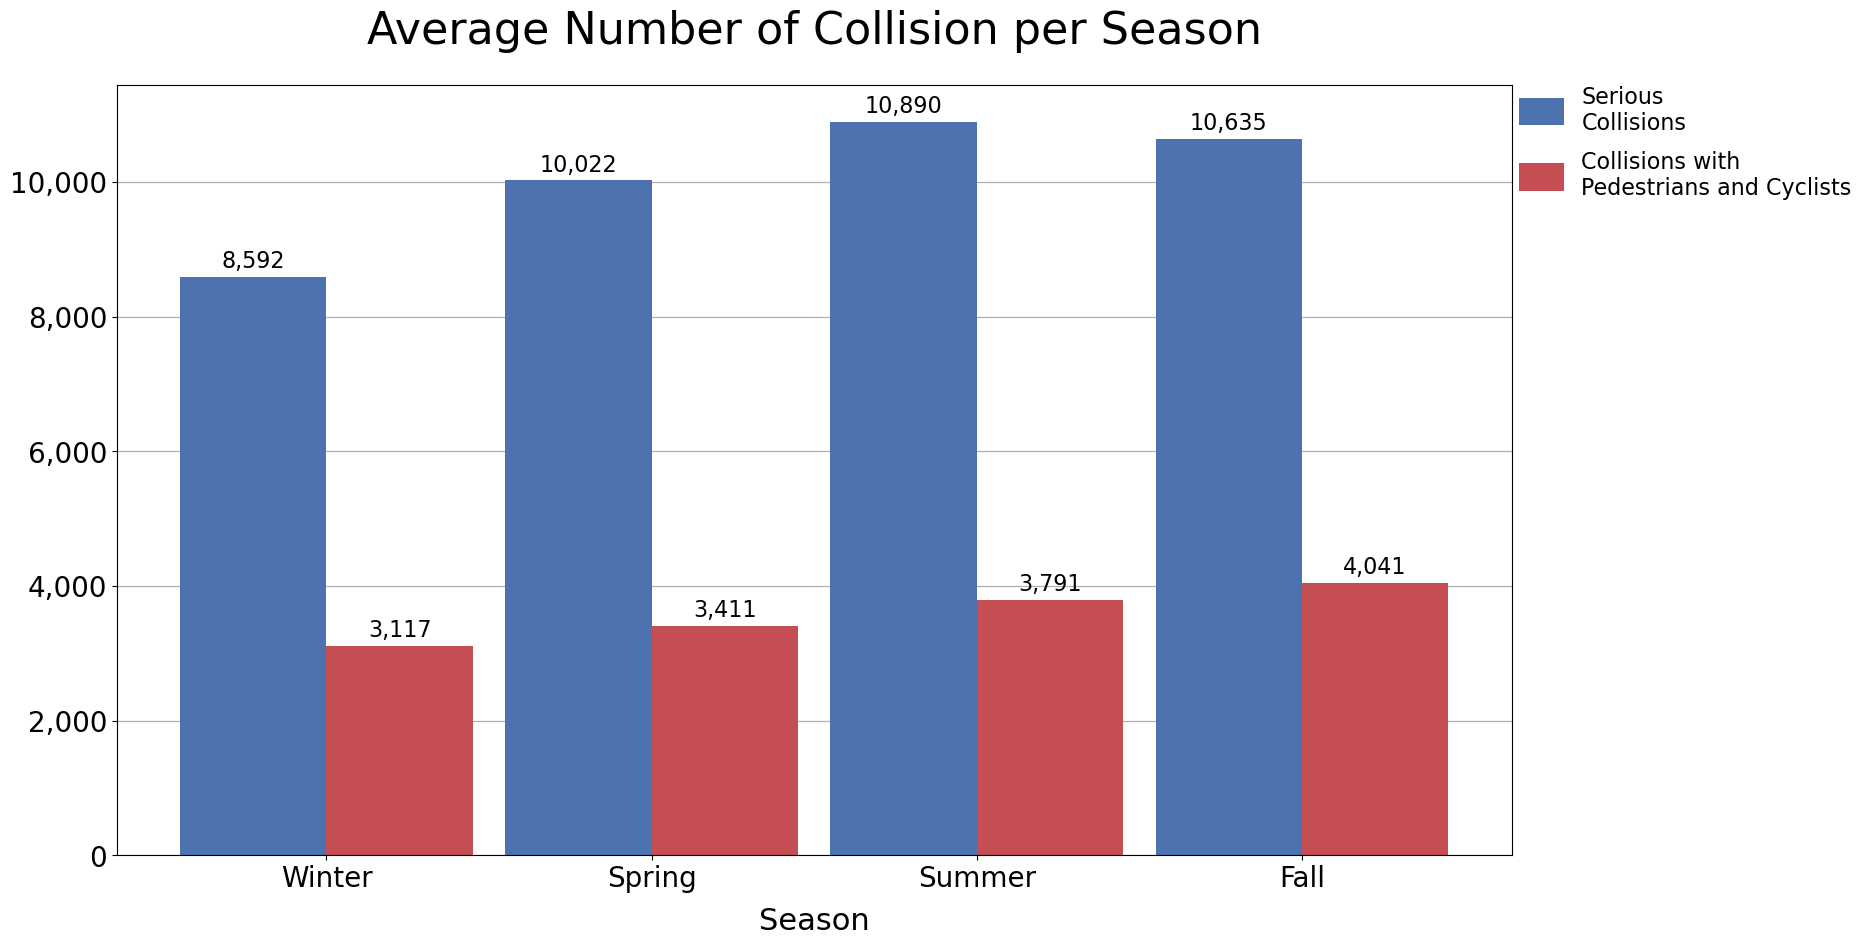

In [19]:
season_groupby = make_collision_groupby(serious, "season", total_years)
season_groupby = season_groupby.reindex(["Winter", "Spring", "Summer", "Fall"])
season_labels = {
    "title": "Average Number of Collision per Season",
    "y_label": "",
    "x_label": "Season",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    season_groupby,
    **season_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    save=os.path.join(IMG_DIR, "trends", "seasonal.png"),
)

Normalized seasonal analysis

In [20]:
seasonl_mta_crossings = (
    mta_crossings.groupby(by="season")["Sum Vehicles"].sum() / MILLION
)
season_groupby_ex_2017 = make_collision_groupby(serious_ex_2017, "season", 1)
cols_to_normalize = ["Serious Collisions", "Non-Motorist Serious"]
season_groupby_ex_2017 = normalize_groupby(
    season_groupby_ex_2017, seasonl_mta_crossings, cols_to_normalize
)

## Normalized Seasonal Variation

- Collisions per million toll crossings are highest in Fall

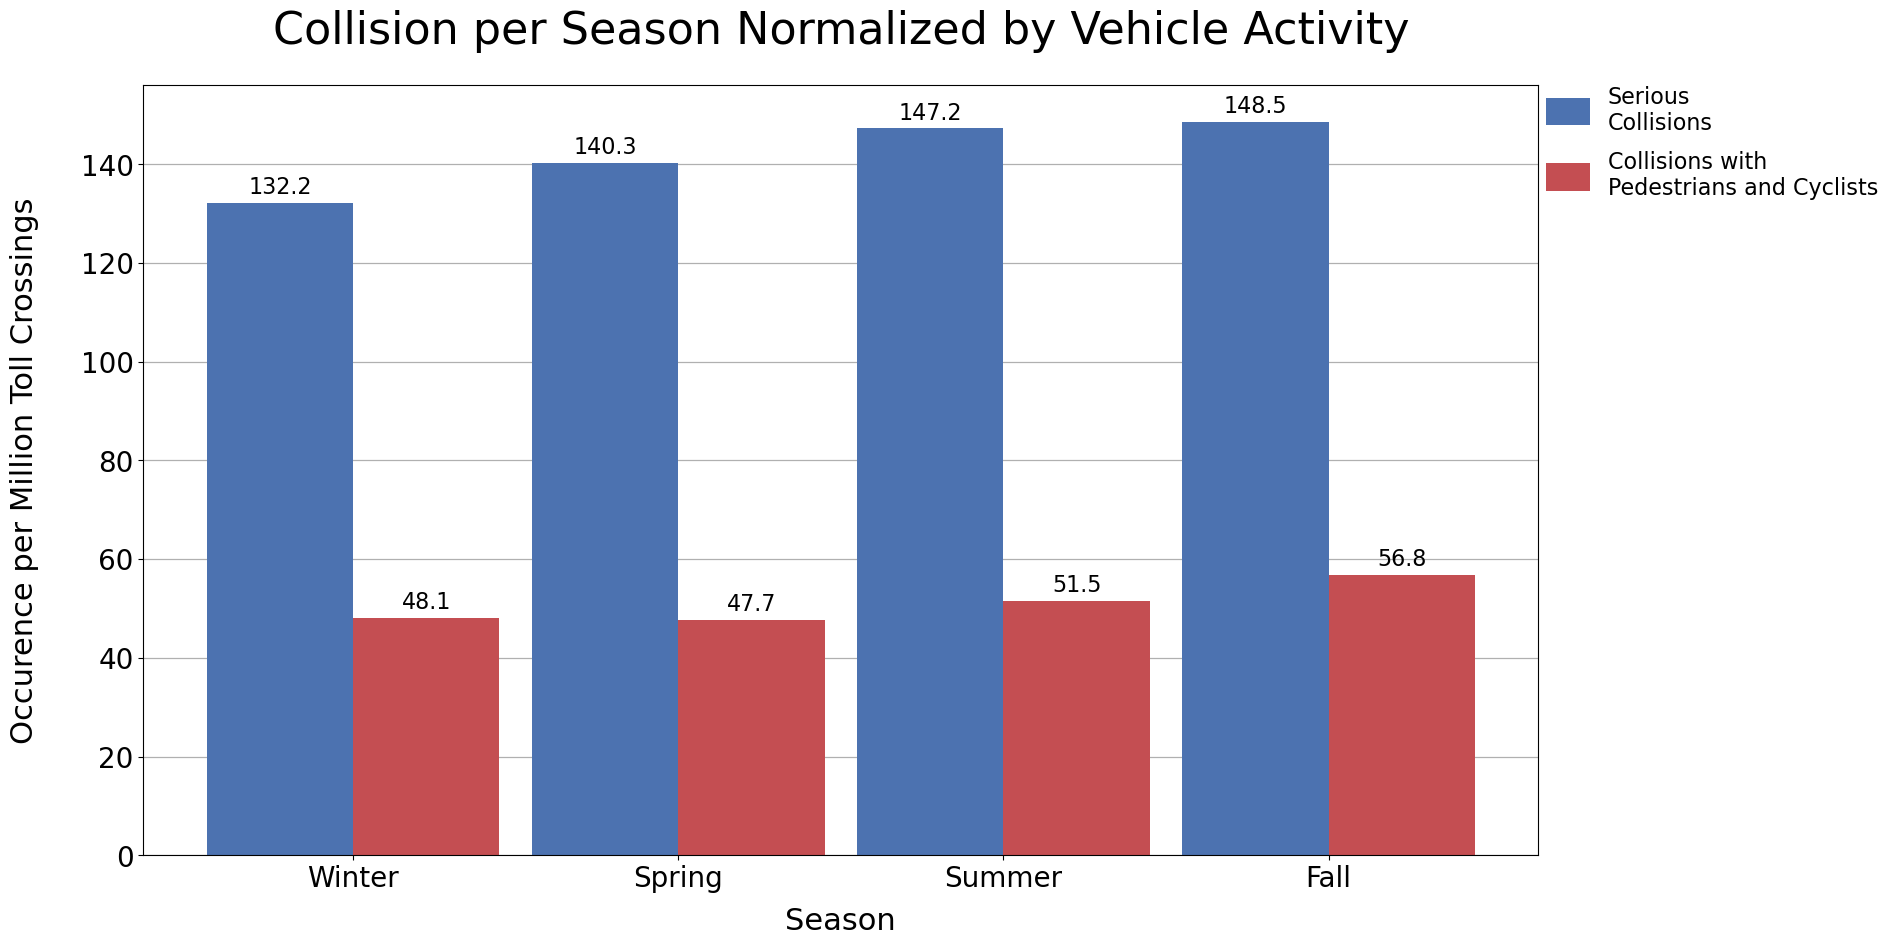

In [21]:
season_groupby_ex_2017 = season_groupby_ex_2017.reindex(
    ["Winter", "Spring", "Summer", "Fall"]
)
season_groupby_ex_2017_labels = {
    "title": "Collision per Season Normalized by Vehicle Activity",
    "y_label": "Occurence per Million Toll Crossings",
    "x_label": "Season",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    season_groupby_ex_2017,
    **season_groupby_ex_2017_labels,
    ylabel_rotation="vertical",
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    bar_digits=1,
    save=os.path.join(IMG_DIR, "trends", "seasonal_norm.png"),
)

## Monthly Variation

- Serious collisions are particularly elevated from May to October
- Collisions with Pedestrians or Cyclists seem to peak in October

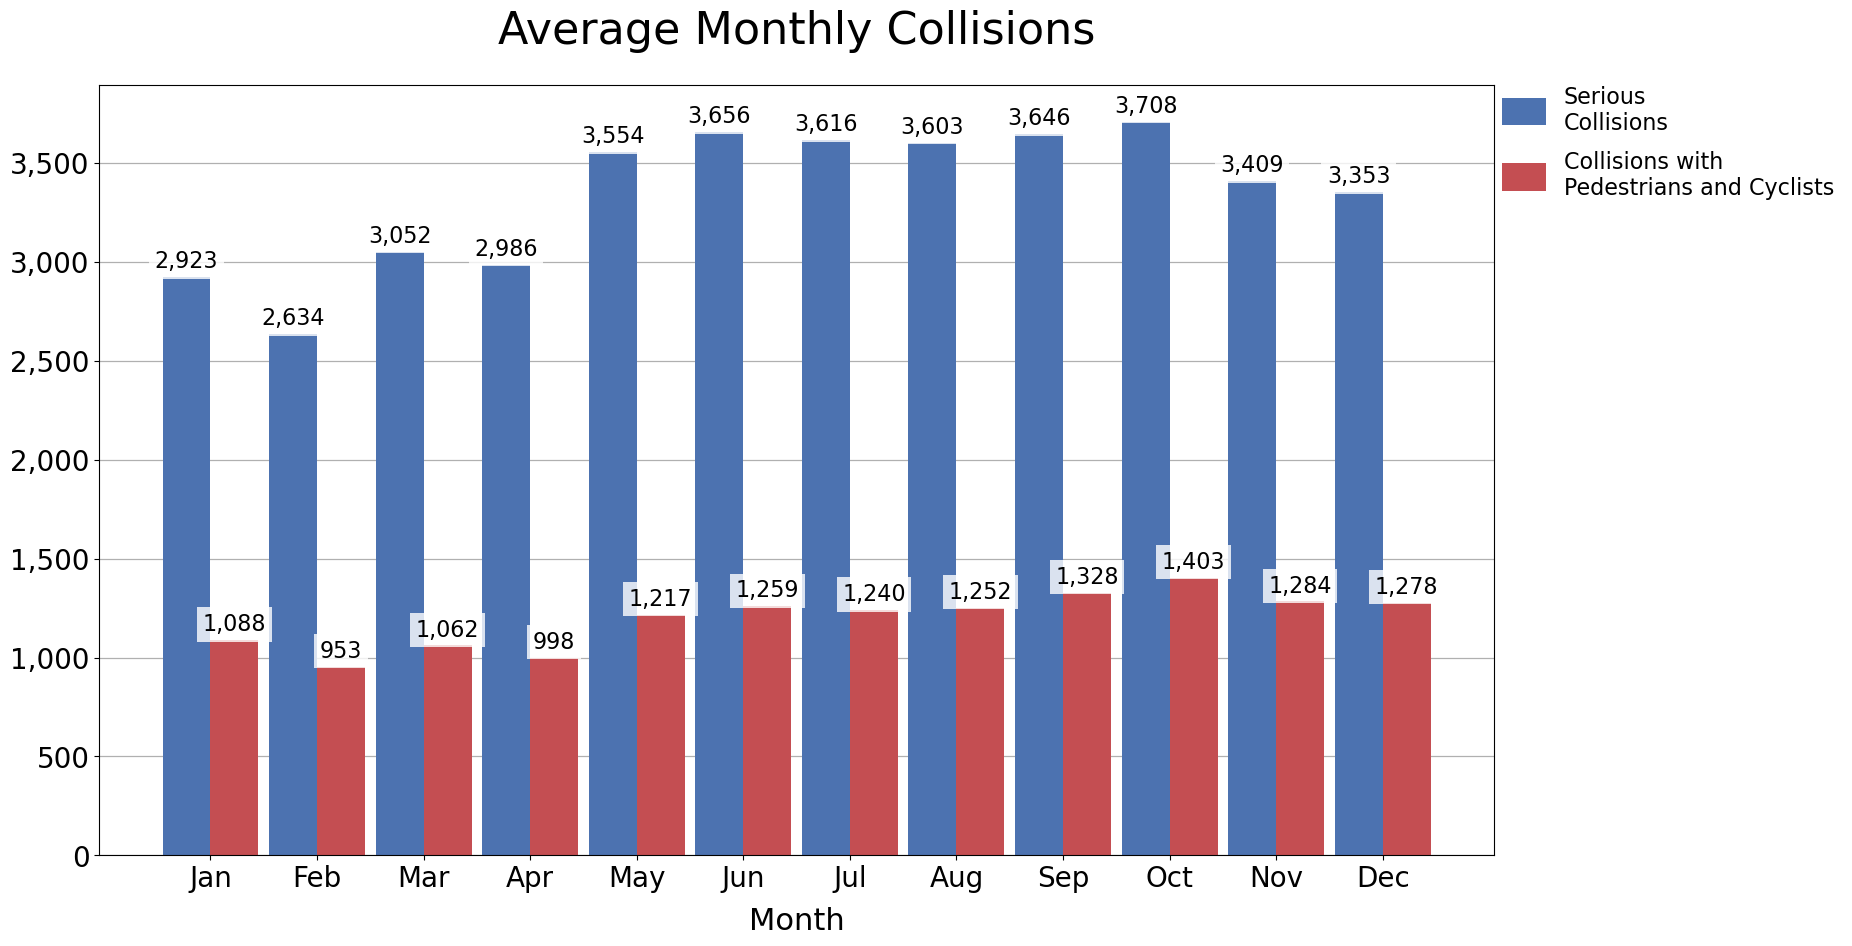

In [22]:
month_groupby = make_collision_groupby(
    serious, serious["datetime"].dt.month, total_years
)
month_groupby.index = month_groupby.index.map(MONTHS_MAP)
month_labels = {
    "title": "Average Monthly Collisions",
    "y_label": "",
    "x_label": "Month",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    month_groupby,
    **month_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "monthly.png"),
)

Normalized monthly analysis

In [23]:
month_mta_crossings = (
    mta_crossings.groupby(by=mta_crossings["datetime"].dt.month)["Sum Vehicles"].sum()
    / MILLION
)
month_groupby_ex_2017 = make_collision_groupby(
    serious_ex_2017, serious_ex_2017["datetime"].dt.month, 1
)
cols_to_normalize = ["Serious Collisions", "Non-Motorist Serious"]
month_groupby_ex_2017 = normalize_groupby(
    month_groupby_ex_2017, month_mta_crossings, cols_to_normalize
)

## Normalized Monthly Variation

- Normalized collisions are particularly elevated from May to October

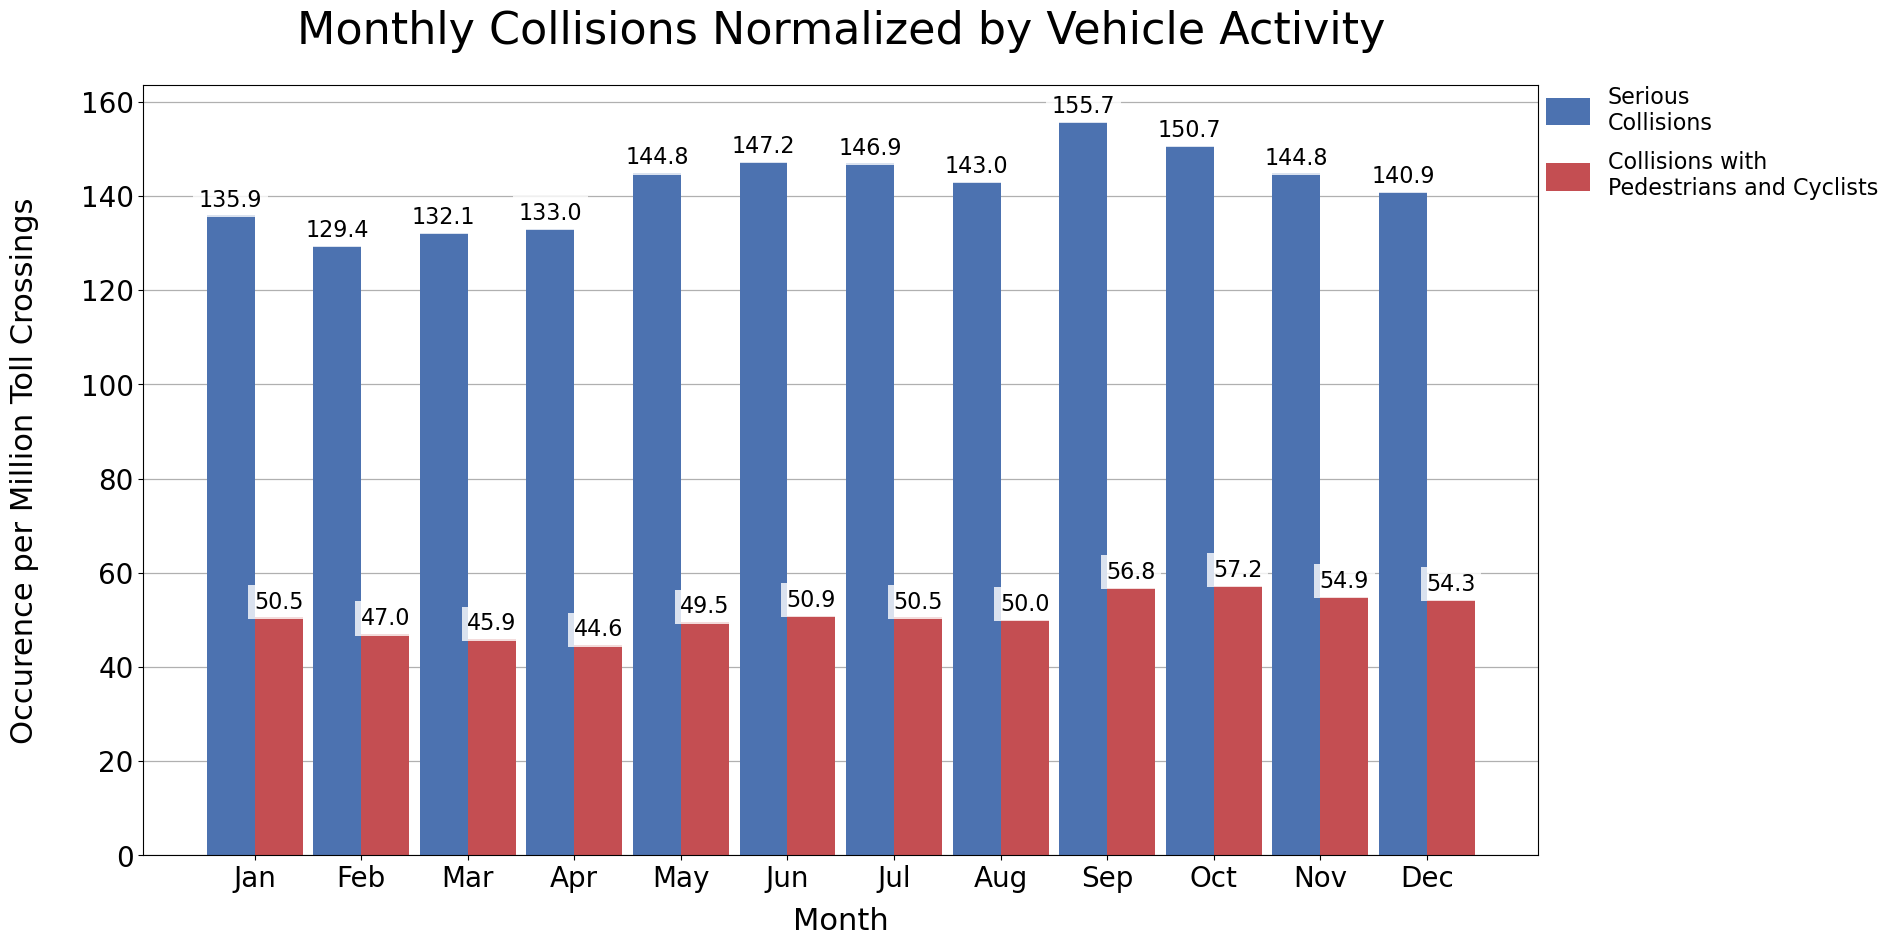

In [24]:
month_groupby_ex_2017.index = month_groupby_ex_2017.index.map(MONTHS_MAP)
month_labels = {
    "title": "Monthly Collisions Normalized by Vehicle Activity",
    "y_label": "Occurence per Million Toll Crossings",
    "x_label": "Month",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    month_groupby_ex_2017,
    **month_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    ylabel_rotation="vertical",
    bar_digits=1,
    save=os.path.join(IMG_DIR, "trends", "monthly_norm.png"),
)

## Weekly Variation

All categories of collisions are most common on Fridays and least common on Sundays

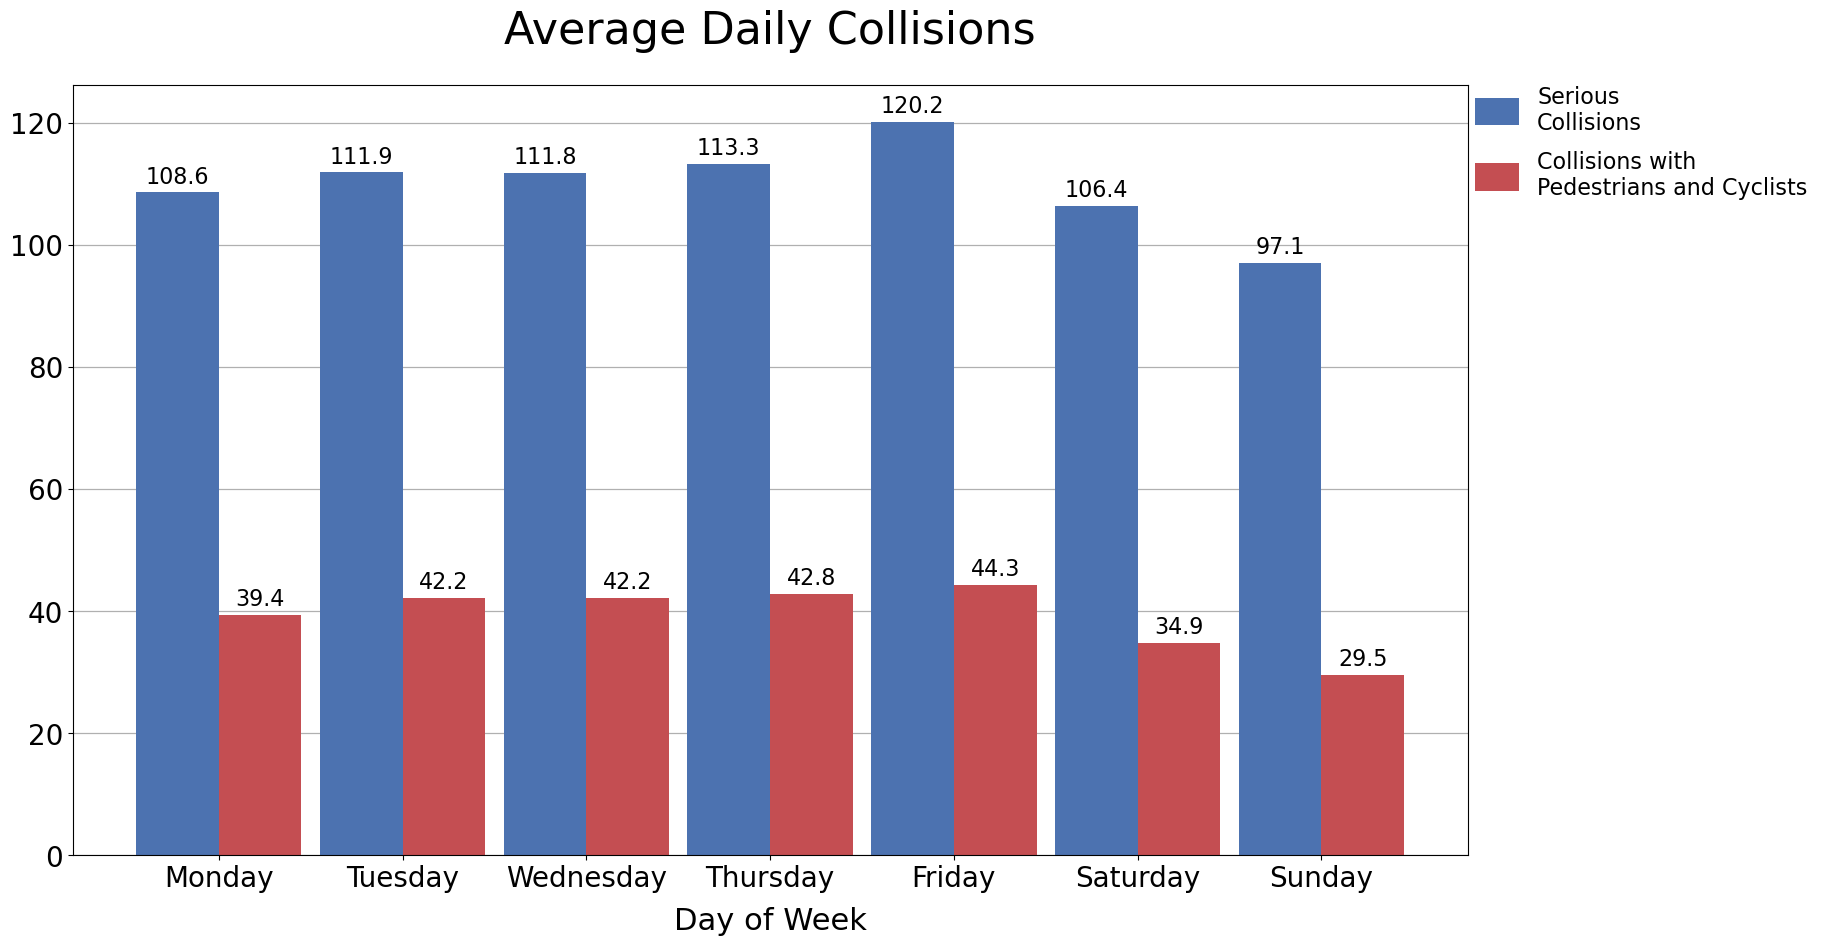

In [25]:
day_groupby = make_collision_groupby(
    serious, serious["datetime"].dt.dayofweek, total_weeks
)
day_groupby.index = day_groupby.index.map(DAY_OF_WEEK_MAP)
day_labels = {
    "title": "Average Daily Collisions",
    "y_label": "",
    "x_label": "Day of Week",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    day_groupby,
    **day_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    bar_digits=1,
    save=os.path.join(IMG_DIR, "trends", "weekly.png"),
)

In [26]:
day_mta_crossings = (
    mta_crossings.groupby(by=mta_crossings["datetime"].dt.dayofweek)[
        "Sum Vehicles"
    ].sum()
    / MILLION
)
day_groupby_ex_2017 = make_collision_groupby(
    serious_ex_2017, serious_ex_2017["datetime"].dt.dayofweek, 1
)
cols_to_normalize = ["Serious Collisions", "Non-Motorist Serious"]
day_groupby_ex_2017 = normalize_groupby(
    day_groupby_ex_2017, day_mta_crossings, cols_to_normalize
)

## Normalized Weekly Variation
- Collisions per day of the week are much more consistent when adjusted for vehicle activity suggesting that the increase in serious collisions from Sunday through Friday reflects increases in traffic volumes

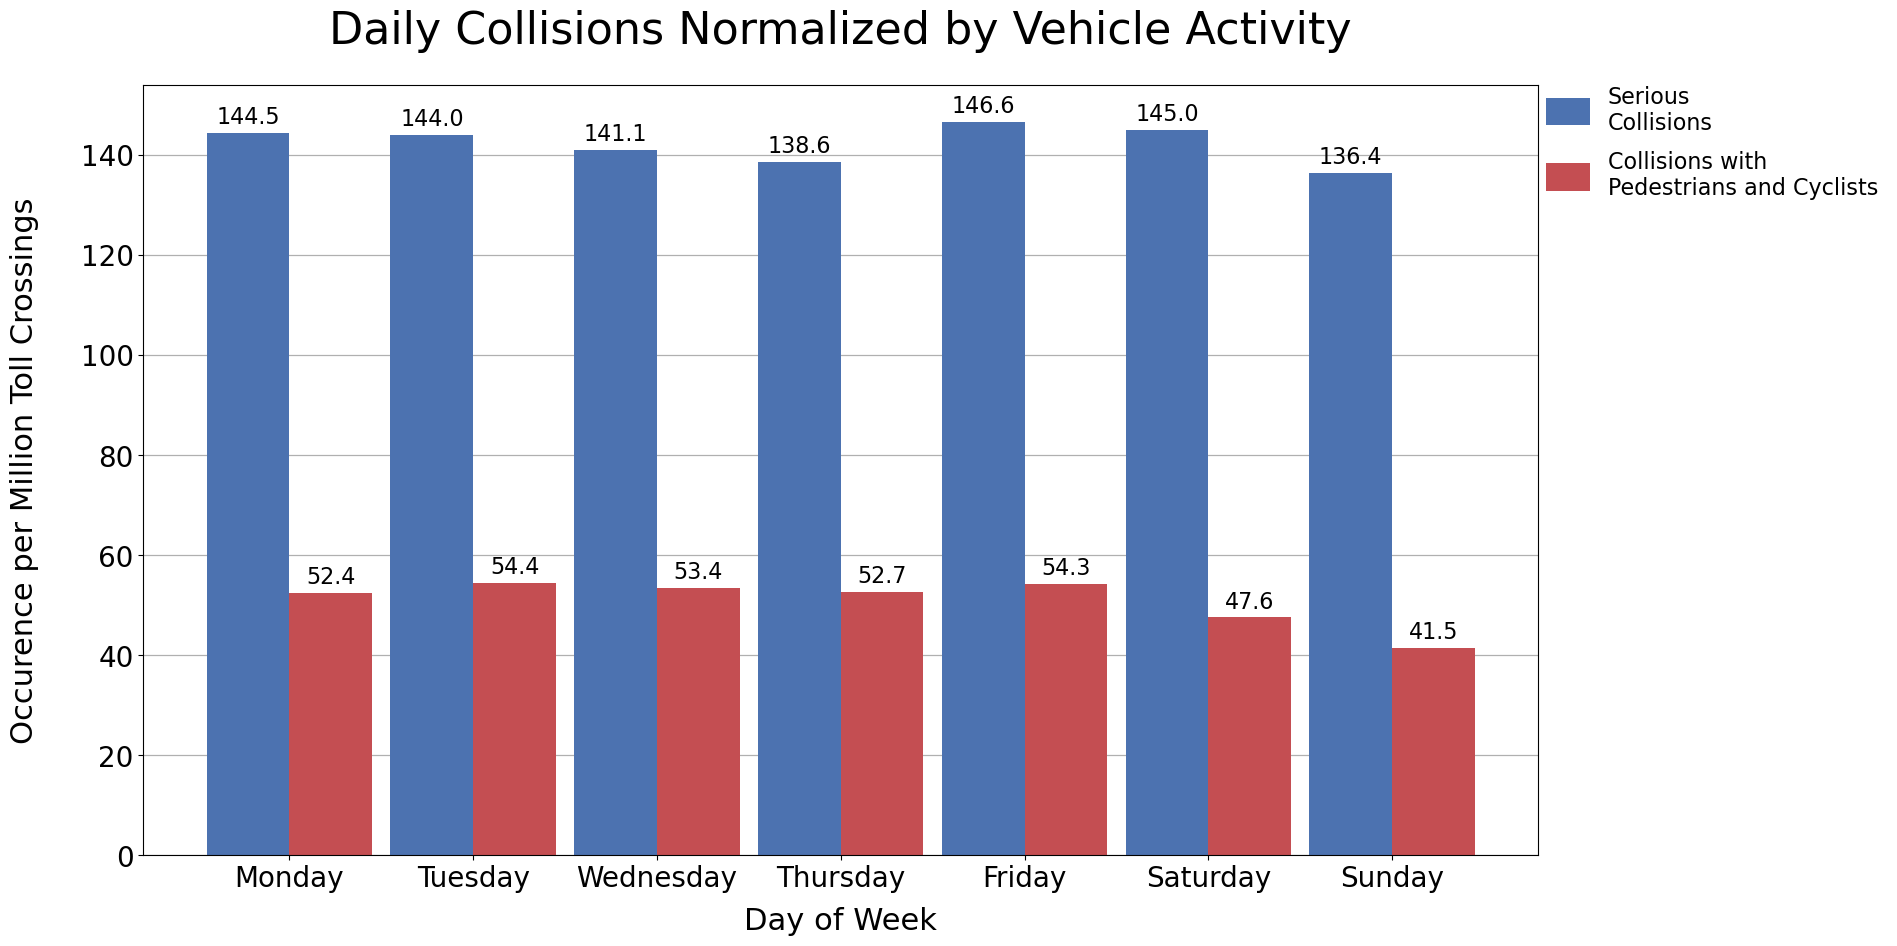

In [27]:
day_groupby_ex_2017.index = day_groupby_ex_2017.index.map(DAY_OF_WEEK_MAP)
day_labels = {
    "title": "Daily Collisions Normalized by Vehicle Activity",
    "y_label": "Occurence per Million Toll Crossings",
    "x_label": "Day of Week",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    day_groupby_ex_2017,
    **day_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    ylabel_rotation="vertical",
    bar_digits=1,
    save=os.path.join(IMG_DIR, "trends", "weekly_norm.png"),
)

## Daily Variation

All categories of collisions are most common in the late afternoon / early evening, ~2-7pm (hours 14-19).

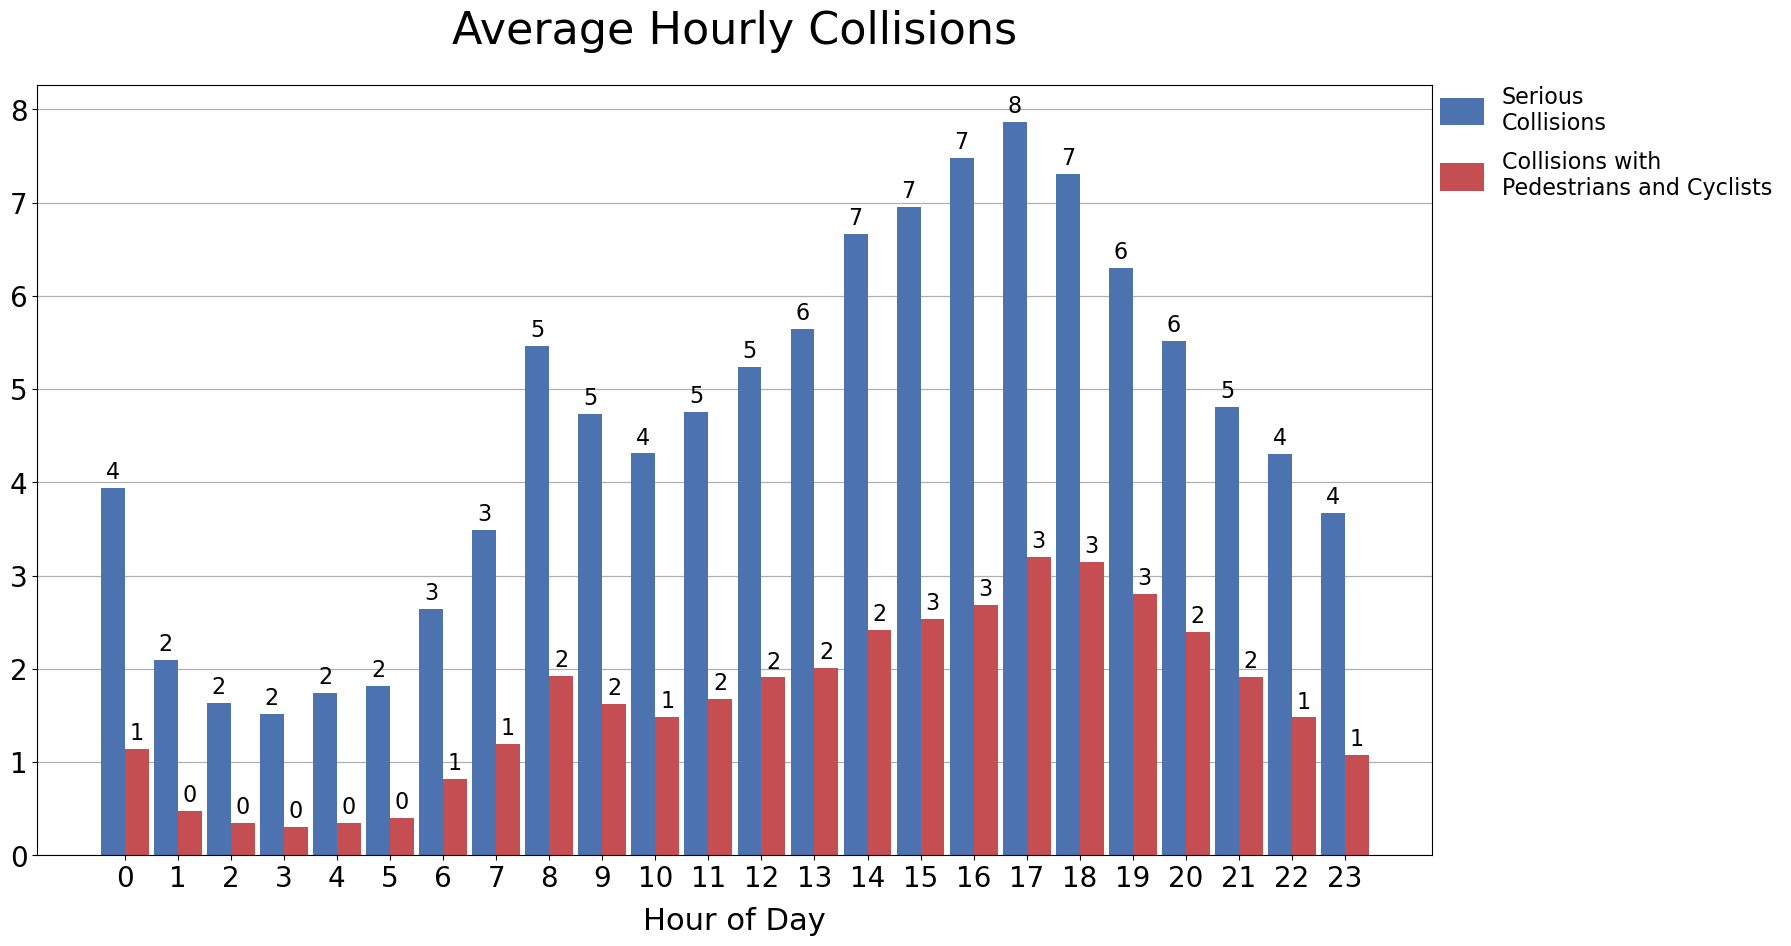

In [28]:
hour_groupby = make_collision_groupby(serious, serious["datetime"].dt.hour, total_days)
hour_labels = {
    "title": "Average Hourly Collisions",
    "y_label": "",
    "x_label": "Hour of Day",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    hour_groupby,
    **hour_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    save=os.path.join(IMG_DIR, "trends", "hourly.png"),
)

In [29]:
hour_mta_crossings = (
    mta_crossings.groupby(by=mta_crossings["datetime"].dt.hour)["Sum Vehicles"].sum()
    / MILLION
)
hour_groupby_ex_2017 = make_collision_groupby(
    serious_ex_2017, serious_ex_2017["datetime"].dt.hour, 1
)
cols_to_normalize = ["Serious Collisions", "Non-Motorist Serious"]
hour_groupby_ex_2017 = normalize_groupby(
    hour_groupby_ex_2017, hour_mta_crossings, cols_to_normalize
)

## Normalized Daily Variation

- Normalized serious collisions are dramatically higher from midnight to 4am
- Normalized collisions with pedestrians and cyclists are elevated from 5pm (1700) to 4am

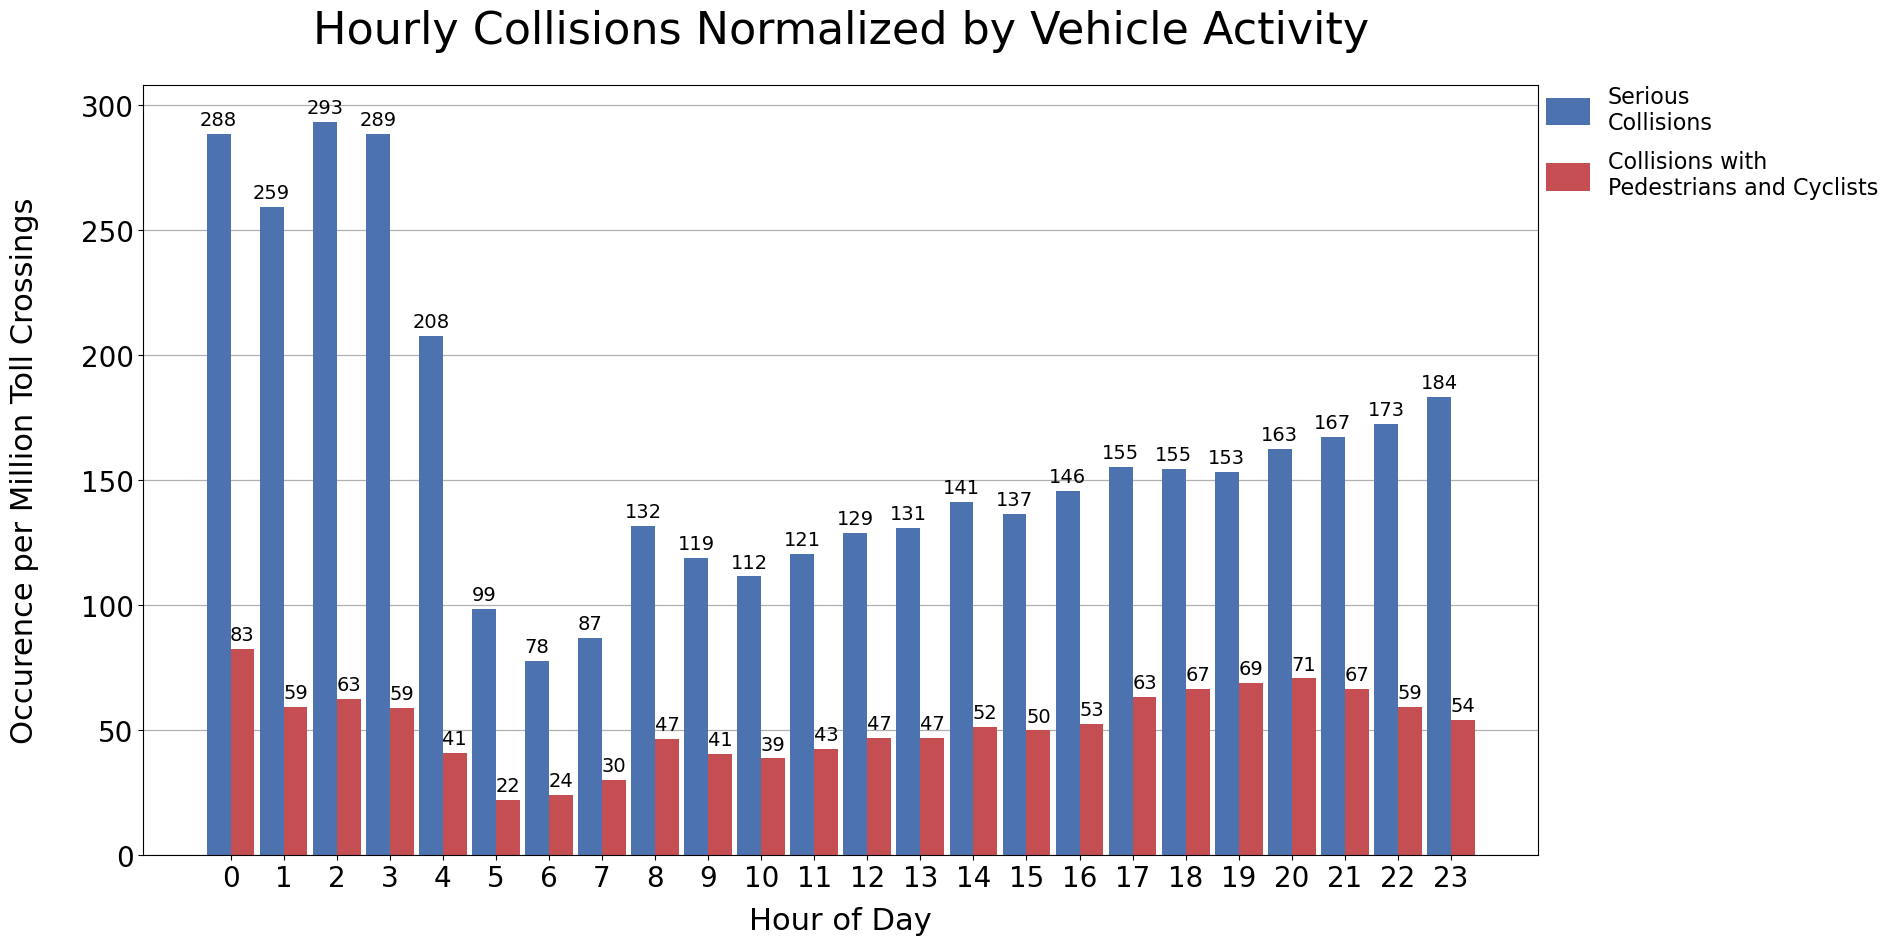

In [30]:
hour_labels = {
    "title": "Hourly Collisions Normalized by Vehicle Activity",
    "y_label": "Occurence per Million Toll Crossings",
    "x_label": "Hour of Day",
}
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians and Cyclists",
]
viz.make_grouped_bar_chart(
    hour_groupby_ex_2017,
    **hour_labels,
    legend_labels=src.strings.add_line_breaks(groups),
    colors=viz.CYCLE_COLORS,
    ylabel_rotation="vertical",
    bar_fontsize=14,
    save=os.path.join(IMG_DIR, "trends", "hourly_norm.png"),
)

# 2D views of when collisions are most common

## Serious Collisions
- Collisions are most common on weekdays in the afternoon / early evening, from approximately 2pm to 7pm (hours 14-19)
- Friday afternoons / early evenings are particularly bad
- Collisions are also elevated during the weekday morning commute, approximately 8am to 10am (hours 8 - 10)
- Early morning collisions, midnight to 6am (hours 0-6), are slightly elevated on the weekends


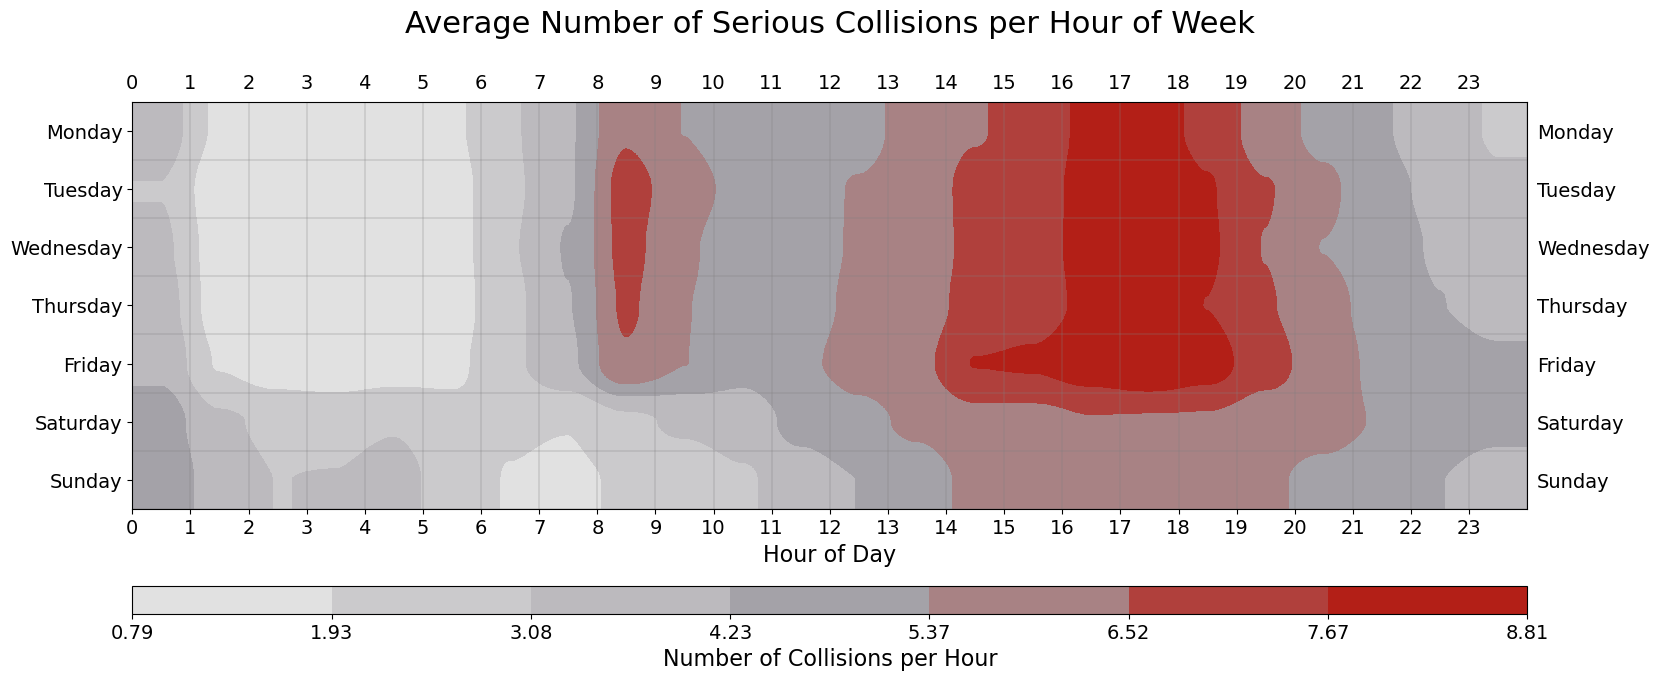

In [31]:
serious_ct = src.utils.make_week_crosstab(
    serious, total_weeks, day_of_week_map=DAY_OF_WEEK_MAP
)
serious_labels = src.utils.make_heatmap_labels(
    "Average Number of Serious Collisions per Hour of Week"
)
viz.make_heat_map(
    serious_ct,
    serious_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "serious_heat.png"),
)

## Normalized Serious Collisions
- Adjusting for traffic levels, serious collisions are dramatically elevated Saturday and Sunday mornings from 2am to 5am
- In general, collisions are elevated at night relative to vehicle activity
- Intoxicated driving may be a key contributor to serious collisions

Preparing cross-tab summing up vehicle crossing per hour per week that will normalize the 2D views

In [32]:
traffic_ct = src.utils.make_week_crosstab(
    mta_crossings,
    1,
    aggfunc="sum",
    values=mta_crossings["Sum Vehicles"],
    day_of_week_map=DAY_OF_WEEK_MAP,
)
traffic_ct /= MILLION

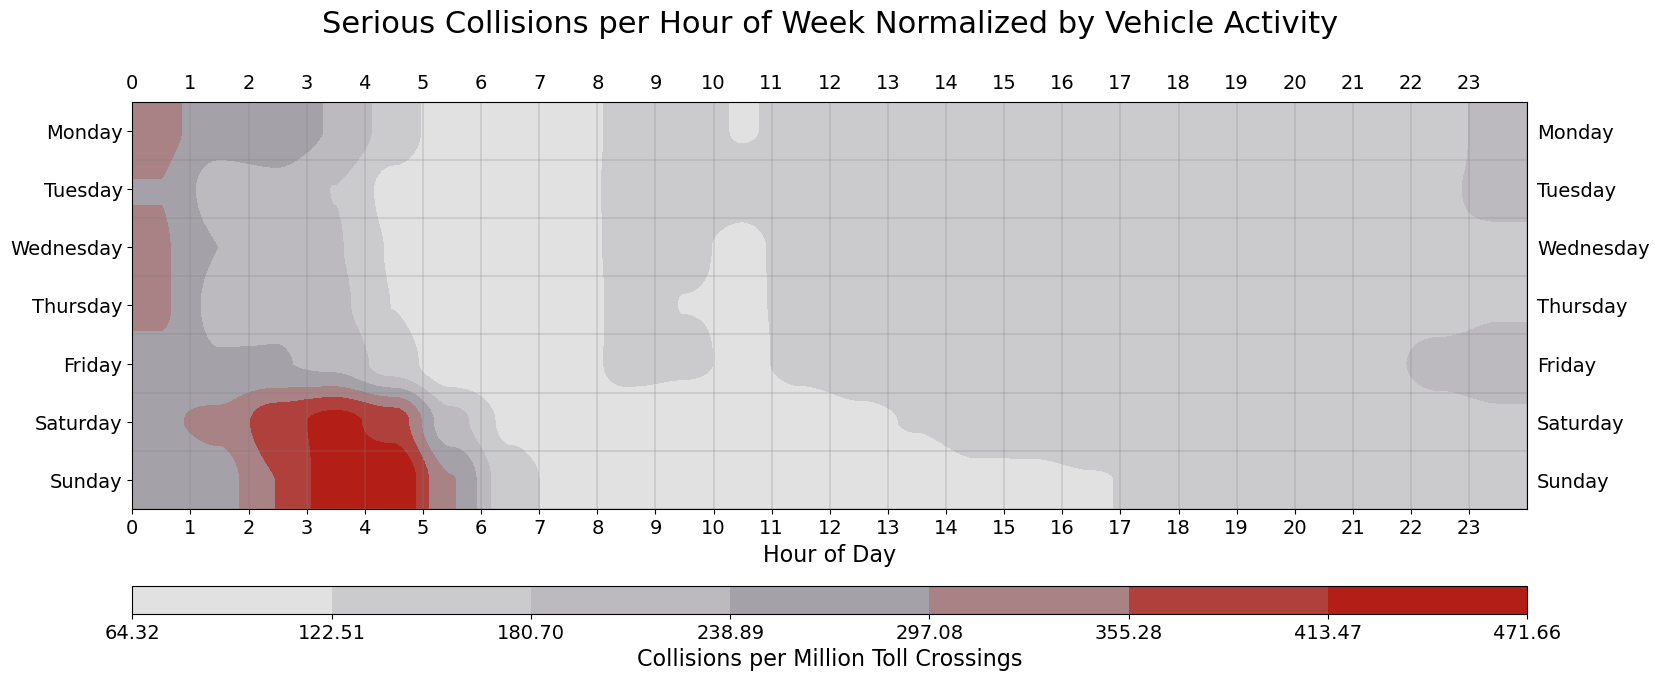

In [33]:
serious_ex_17_ct = src.utils.make_week_crosstab(
    serious_ex_2017, 1, day_of_week_map=DAY_OF_WEEK_MAP
)
serious_ct_norm = serious_ex_17_ct / traffic_ct

serious_labels = src.utils.make_heatmap_labels(
    "Serious Collisions per Hour of Week Normalized by Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.make_heat_map(
    serious_ct_norm,
    serious_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "serious_heat_norm.png"),
)

## Fatal Collisions
- The most prominent cluster of fatalities occurs Saturday and Sunday mornings between 3am and 5am. Intoxication can be presumed to be a major factor in these fatal collisions. Many bars and clubs close around 4am in NYC. 
- A secondary cluster of fatalities occurs Fridays and Saturdays between 5pm and 7pm (hours 17-19)
- Fatal collisions are generally elevated from 5pm to 1am (hours 17 - 1)

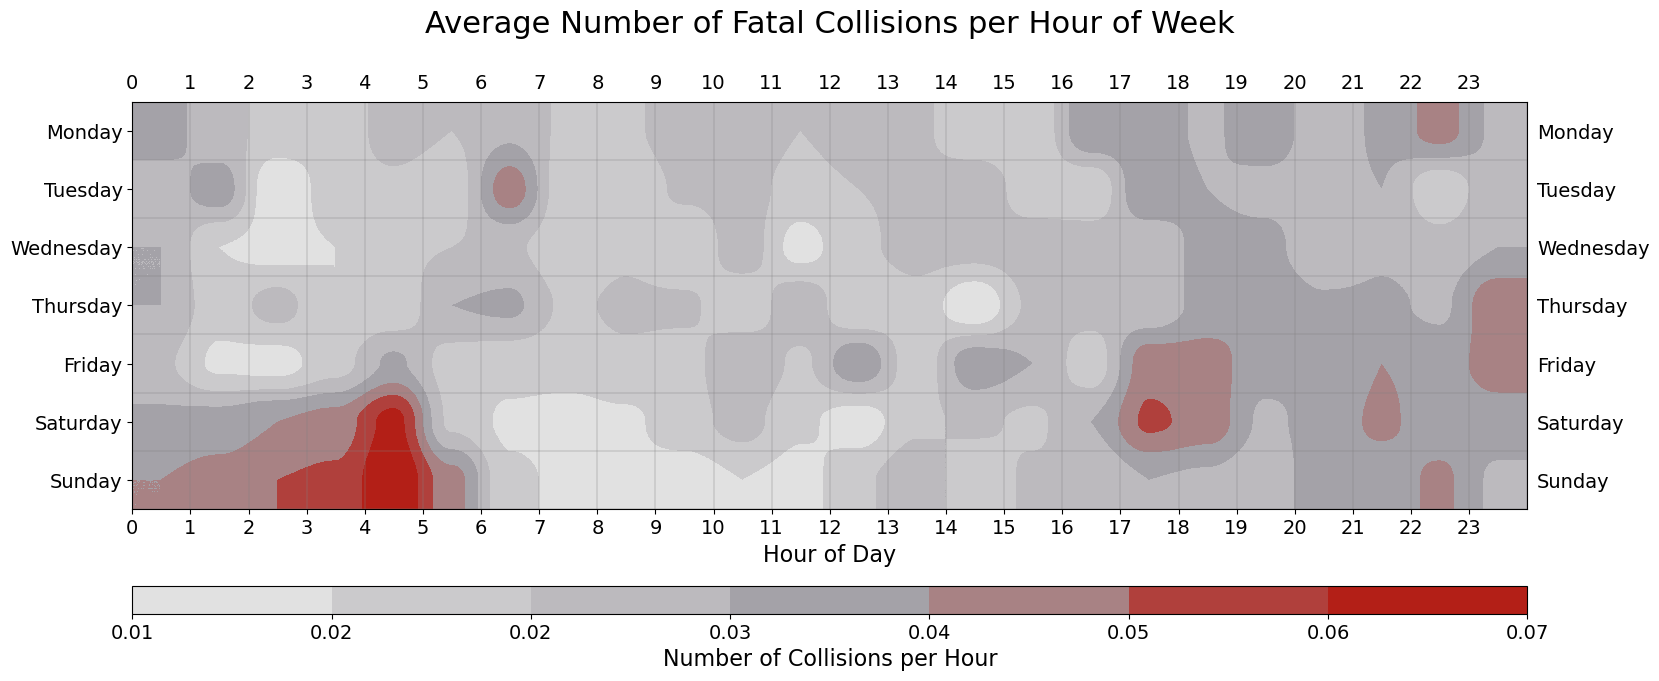

In [34]:
fatal = serious[serious["Total Killed"] > 0]
fatal_ct = src.utils.make_week_crosstab(
    fatal, total_weeks, day_of_week_map=DAY_OF_WEEK_MAP
)
fatal_labels = src.utils.make_heatmap_labels(
    "Average Number of Fatal Collisions per Hour of Week"
)
viz.make_heat_map(
    fatal_ct,
    fatal_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    cbar_format=lambda x: f"{x:.2f}",
    save=os.path.join(IMG_DIR, "trends", "fatal_heat.png"),
)

## Normalized Fatal Collisions
- Fatal collisions are notable higher Saturday and Sunday mornings from 2am to 5am

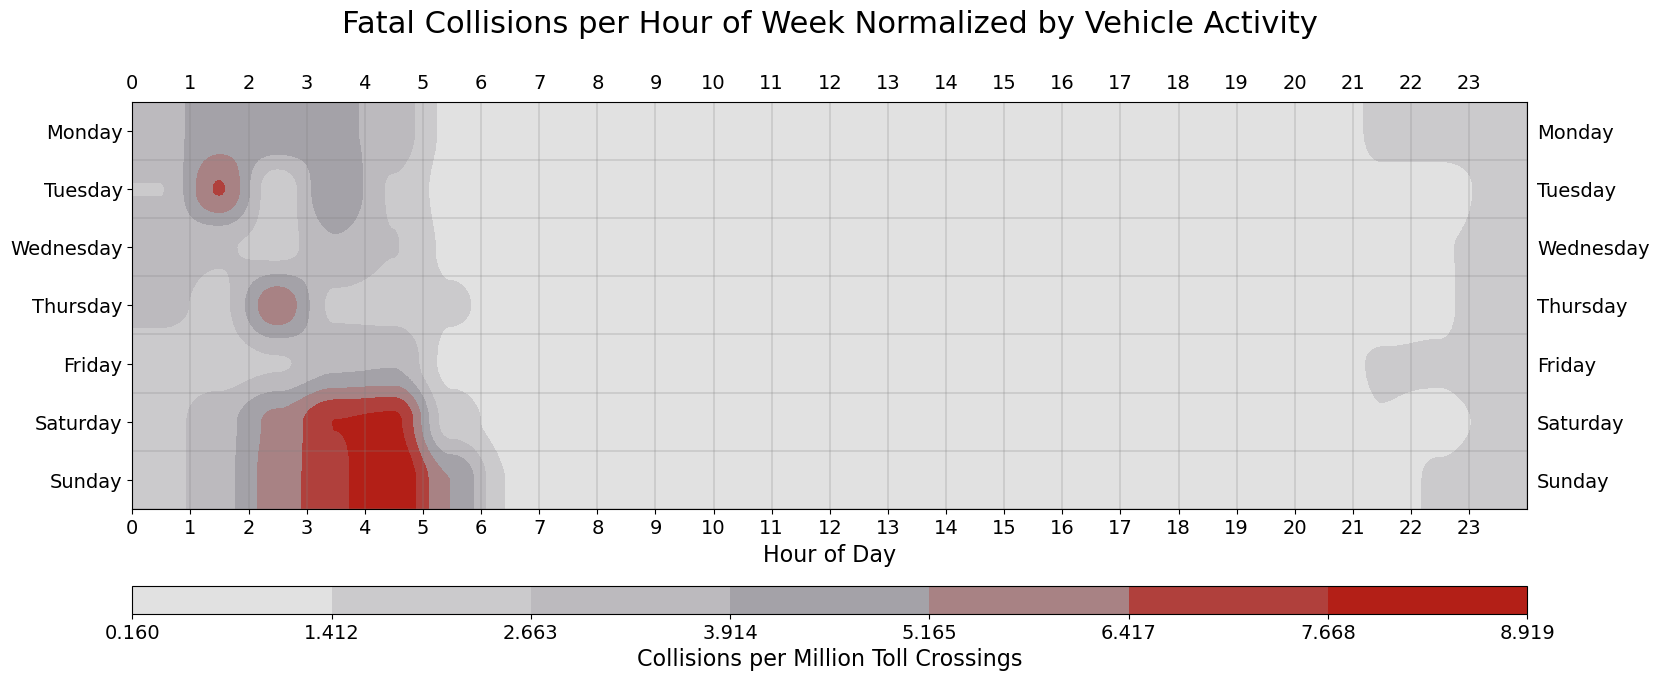

In [35]:
fatal_ex_17 = serious_ex_2017[serious_ex_2017["Total Killed"] > 0]
fatal_ex_17_ct = src.utils.make_week_crosstab(
    fatal_ex_17, 1, day_of_week_map=DAY_OF_WEEK_MAP
)
fatal_ct_norm = fatal_ex_17_ct / traffic_ct

fatal_labels = src.utils.make_heatmap_labels(
    "Fatal Collisions per Hour of Week Normalized by Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.make_heat_map(
    fatal_ct_norm,
    fatal_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    cbar_format=lambda x: f"{x:.3f}",
    save=os.path.join(IMG_DIR, "trends", "fatal_heat_norm.png"),
)

## Collisions with Pedestrians and Cyclists

- Collisions with pedestrians and cyclists are most common during weekday afternoons and evenings
- Additionally, collisions are elevated weekday mornings and weekend afternoons and evenings

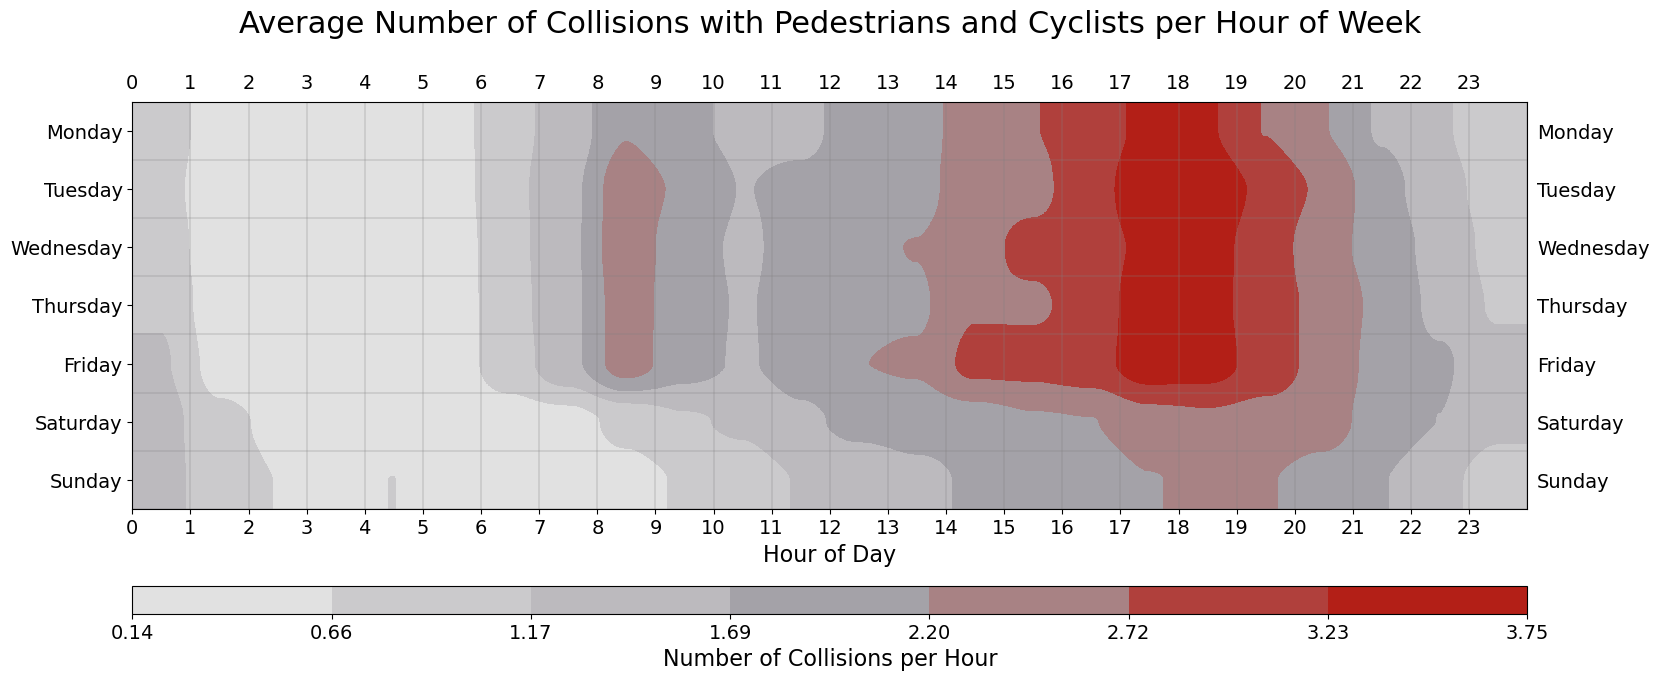

In [36]:
non_motorist_ct = src.utils.make_week_crosstab(
    non_motorist, total_weeks, day_of_week_map=DAY_OF_WEEK_MAP
)
non_motorist_labels = src.utils.make_heatmap_labels(
    "Average Number of Collisions with Pedestrians and Cyclists per Hour of Week"
)
viz.make_heat_map(
    non_motorist_ct,
    non_motorist_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "non_motor_heat.png"),
)

## Normalized Collisions with Pedestrians and Cyclists
- Adjusting for traffic levels, collisions with pedestrians and cyclists are very high from midnight to 1am on weeknights
- Normalized collisions are elevated from 5pm to 10pm on weekdays
- On weekends, normalized collisions are highest from midnight to 5am

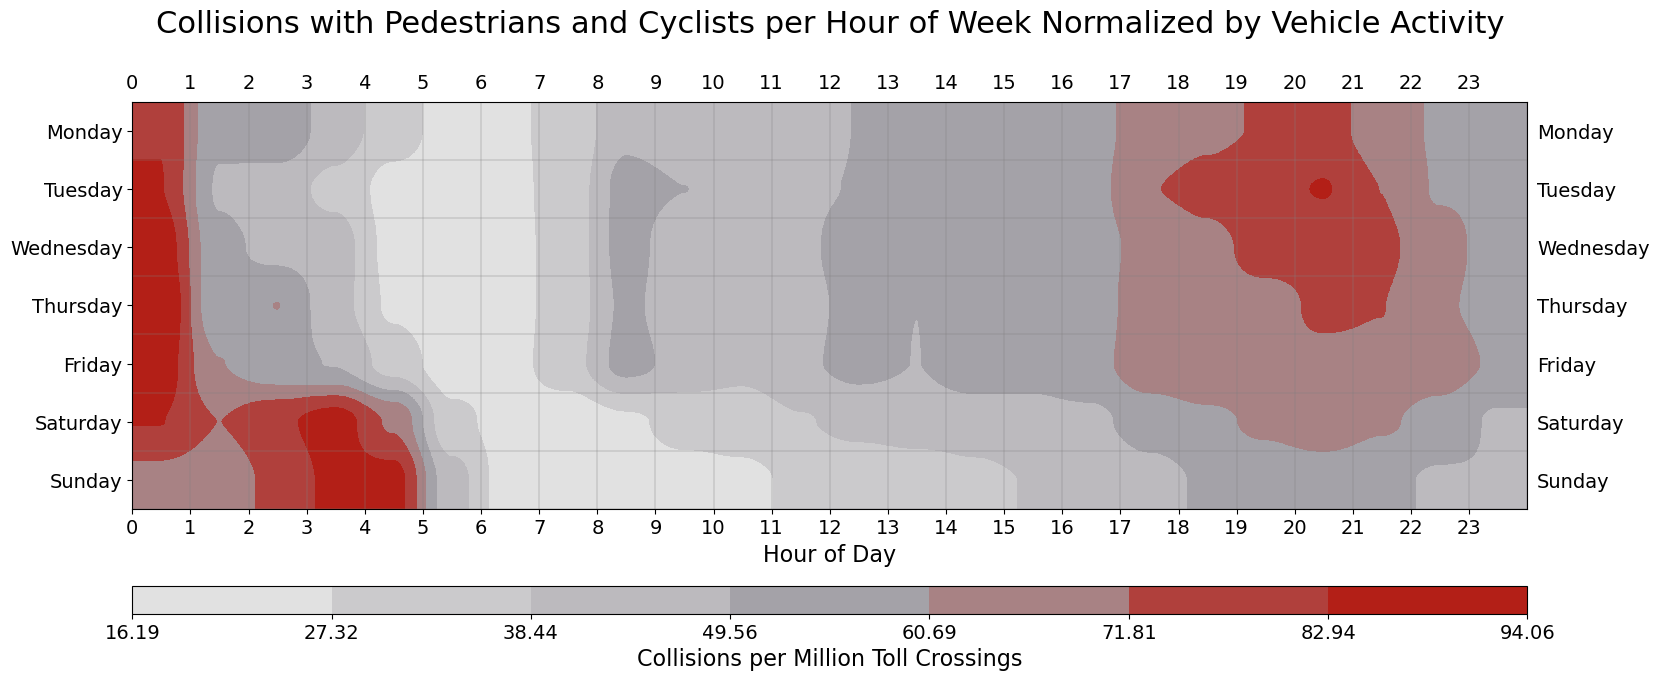

In [37]:
non_motorist_ex_17_ct = src.utils.make_week_crosstab(
    non_motorist_ex_2017, 1, day_of_week_map=DAY_OF_WEEK_MAP
)

non_motorist_ct_norm = non_motorist_ex_17_ct / traffic_ct
non_motorist_labels = src.utils.make_heatmap_labels(
    "Collisions with Pedestrians and Cyclists per Hour of Week Normalized by Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.make_heat_map(
    non_motorist_ct_norm,
    non_motorist_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    cbar_format=lambda x: f"{x:.2f}",
    save=os.path.join(IMG_DIR, "trends", "non_motor_heat_norm.png"),
)

## Weekly Serious Collisions Through the Seasons

- Serious collisions are less common in the winter
- There is a notable cluster of serious collisions during fall weekday mornings
- Summer appears to have more serious collisions at night, ~8pm - 5am (hours 20-5) than other seasons

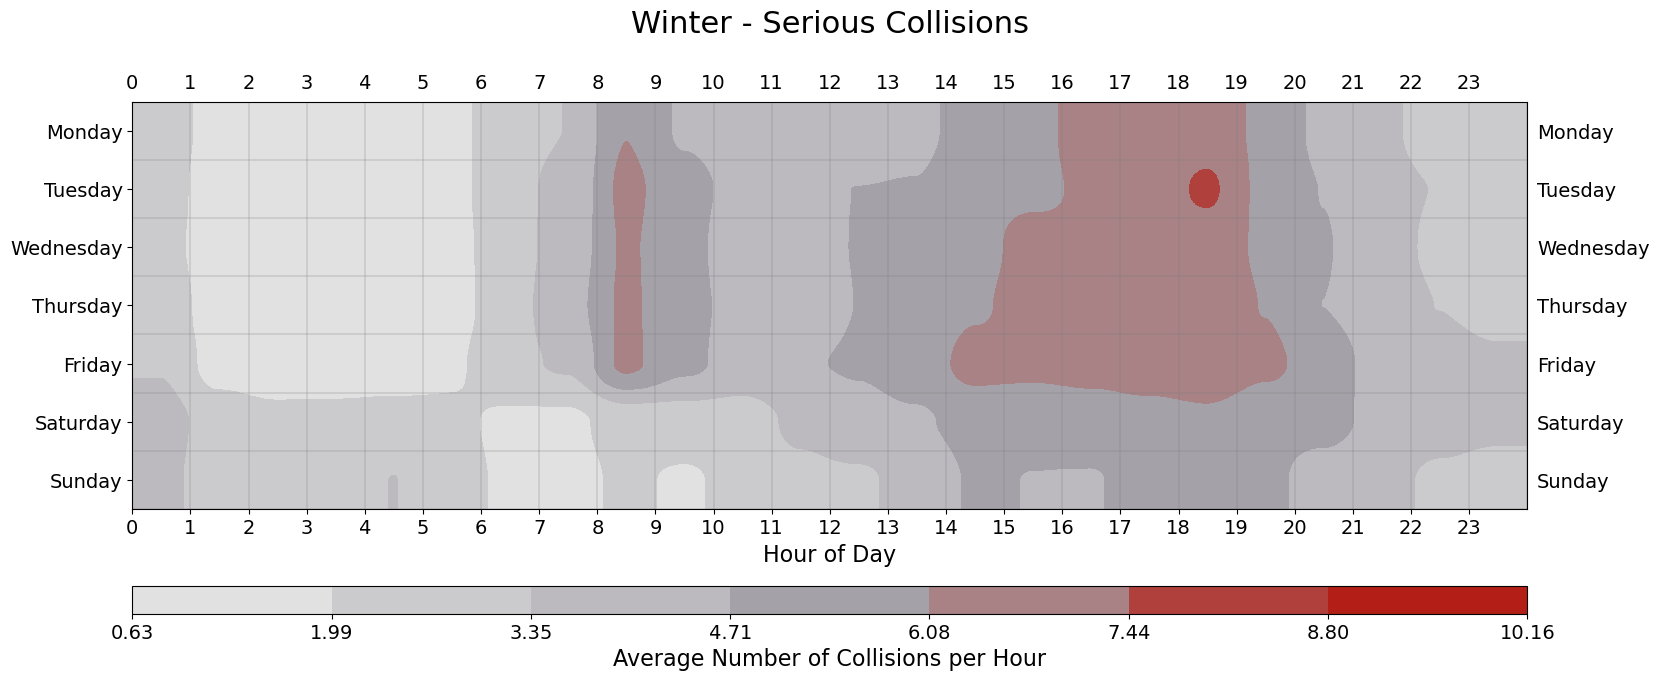

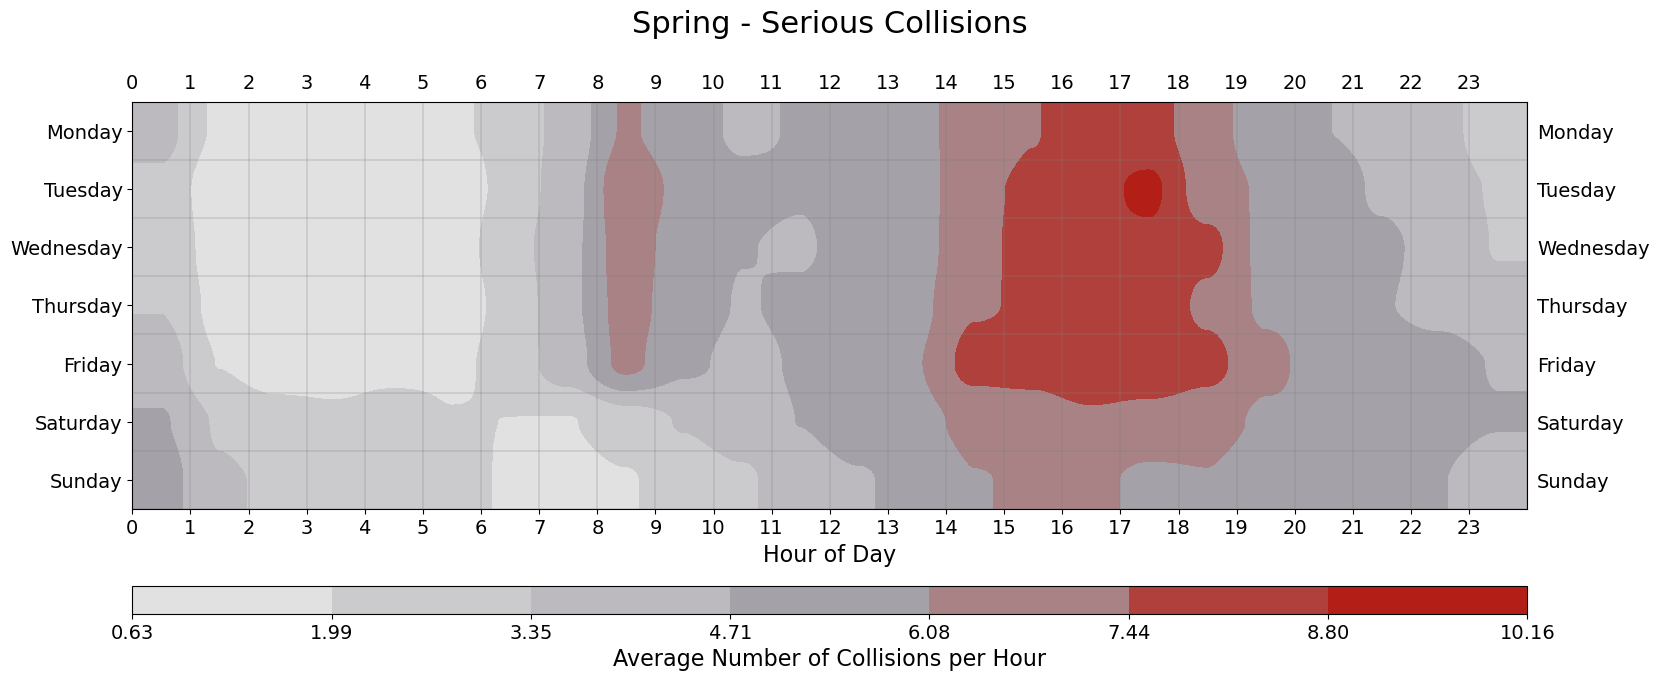

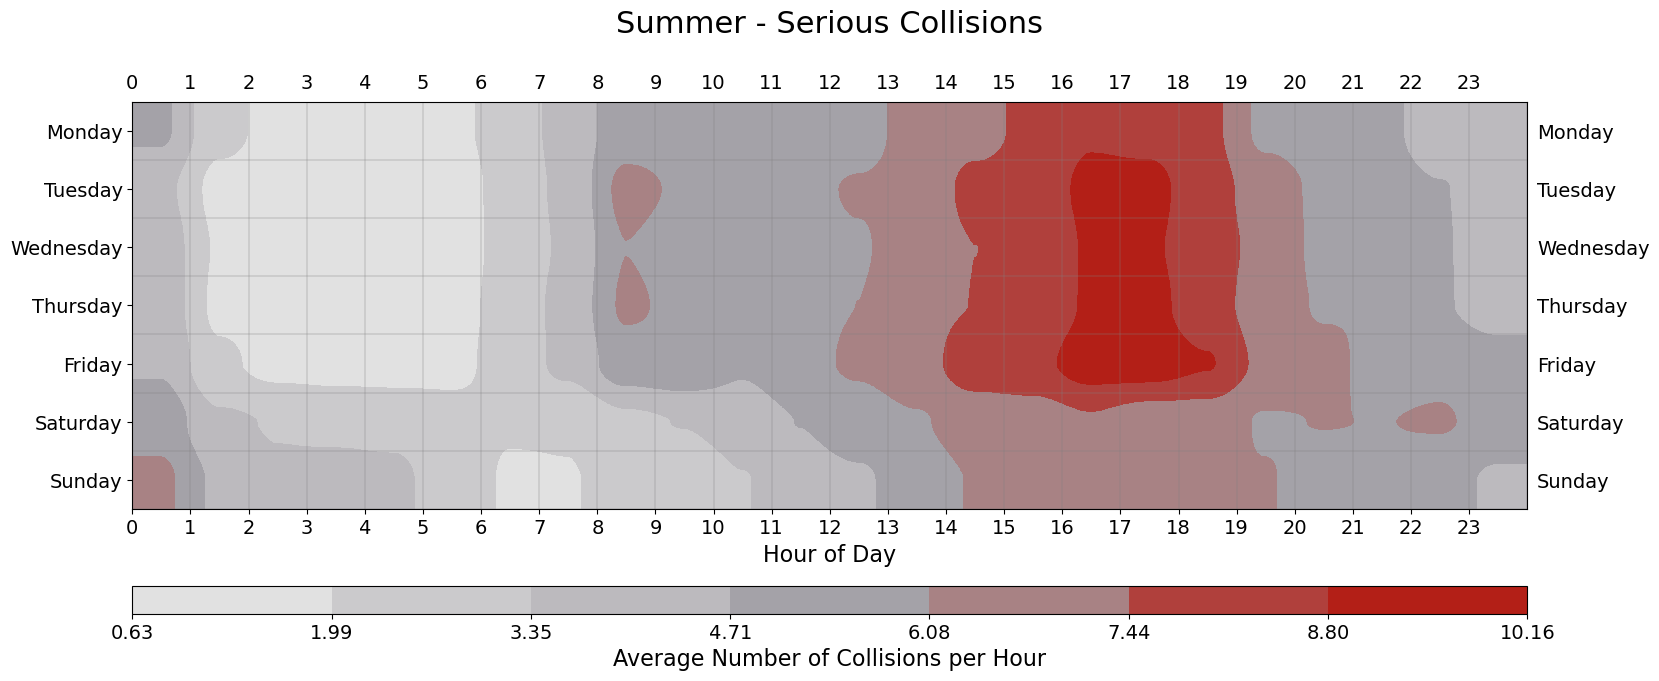

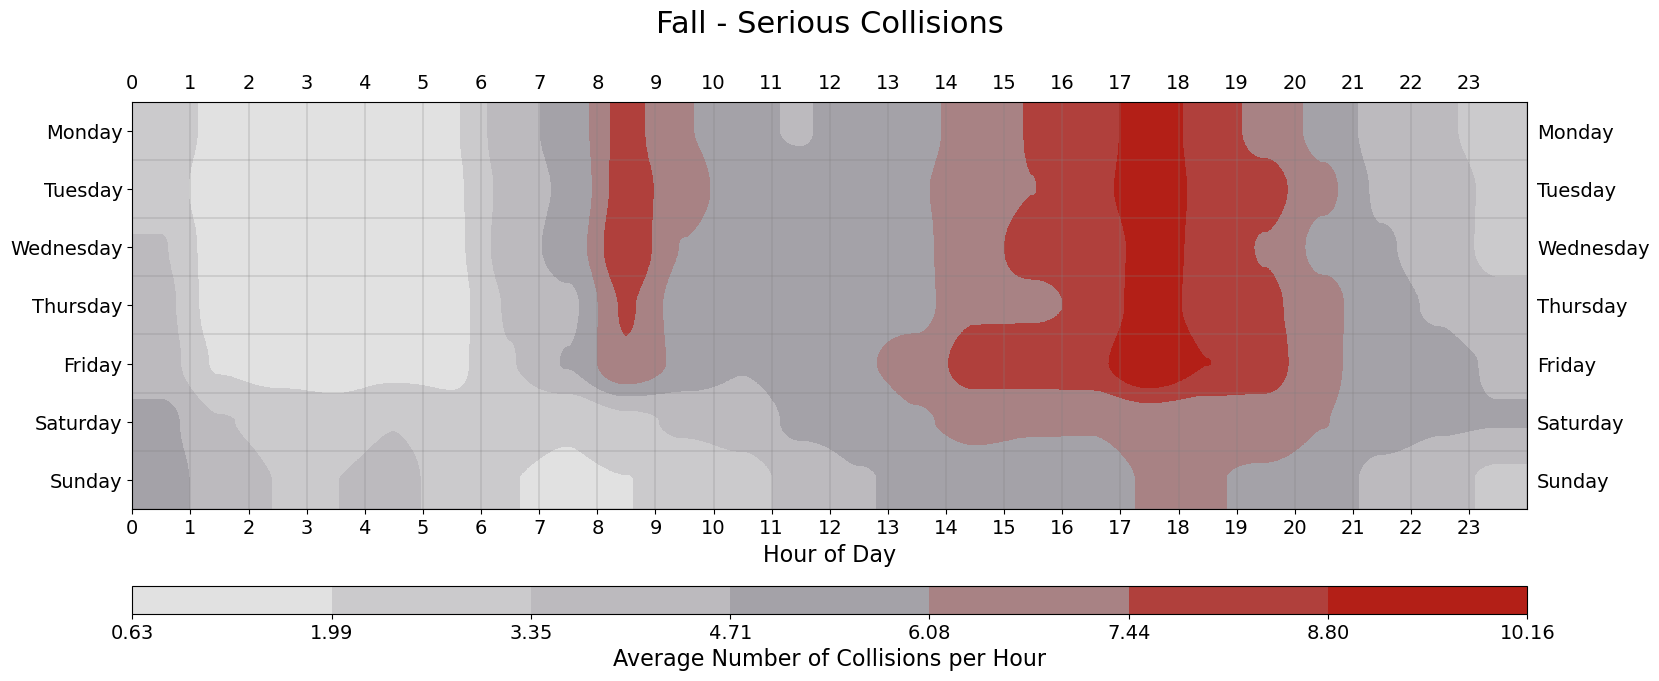

In [38]:
mn_mx_serious = src.utils.get_crosstab_min_max(
    serious, "season", SEASONS, divisor=(total_weeks / 4)
)
for season in SEASONS:
    season_df = serious[serious["season"] == season]
    season_ct = src.utils.make_week_crosstab(
        season_df, (total_weeks / 4), day_of_week_map=DAY_OF_WEEK_MAP
    )
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Serious Collisions",
        cbar_label="Average Number of Collisions per Hour",
    )
    viz.make_heat_map(
        season_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_serious,
        save=os.path.join(IMG_DIR, "trends", season.lower() + "_serious_heat.png"),
    )

## Normalized Weekly Serious Collisions Through the Seasons

- Serious collisions normalized for vehicle activity are fairly consistent throughout the seasons
- There is a slightly elevated risk in the early morning hours during the summer

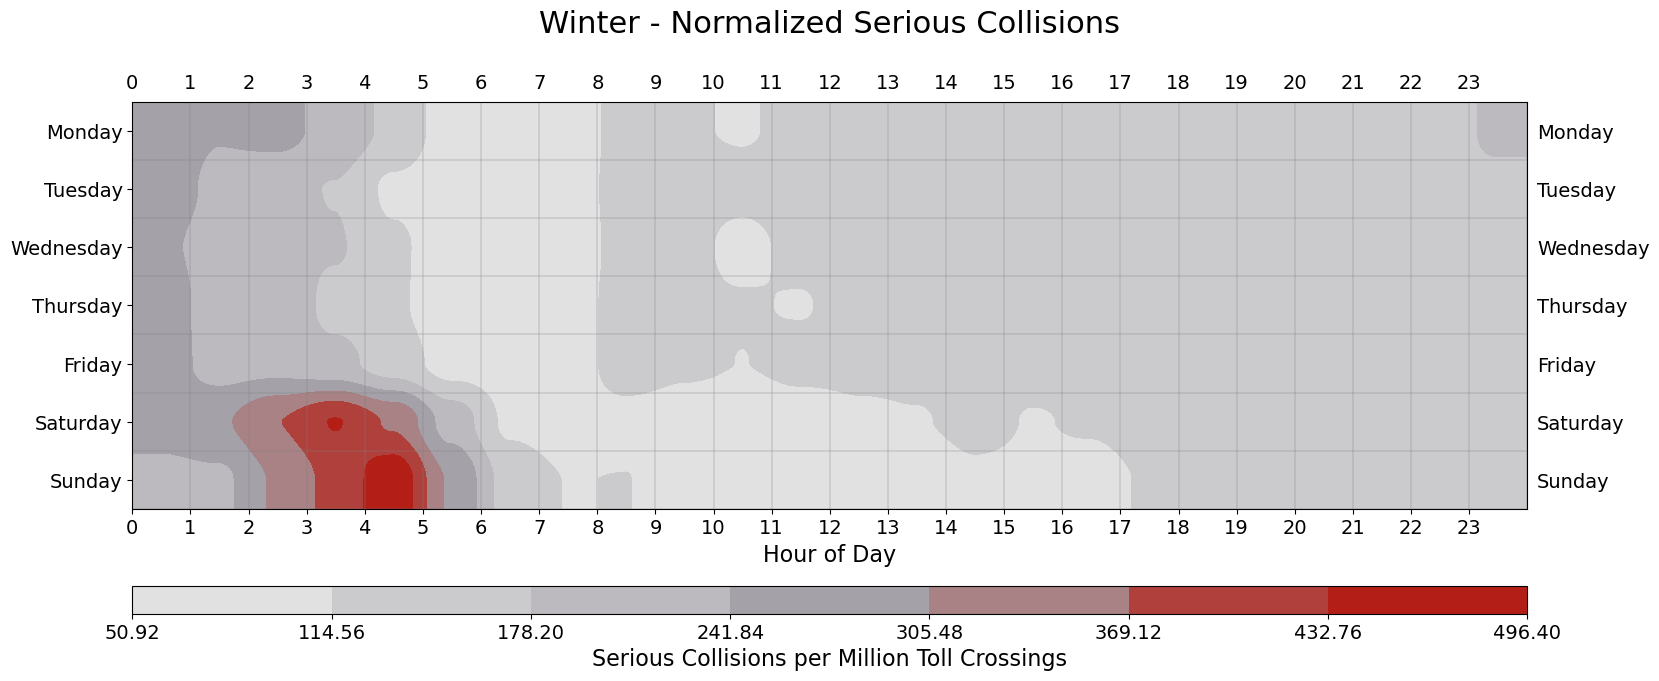

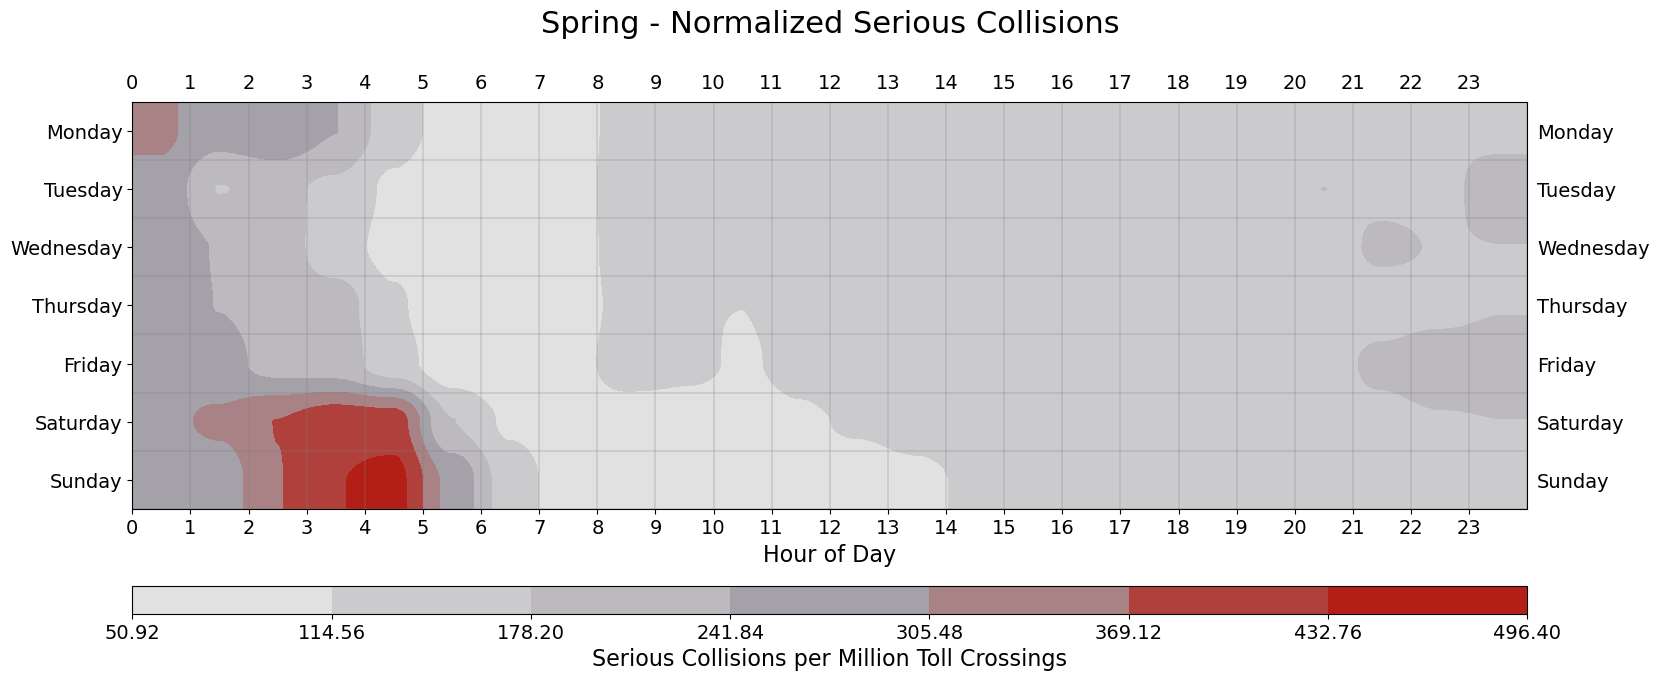

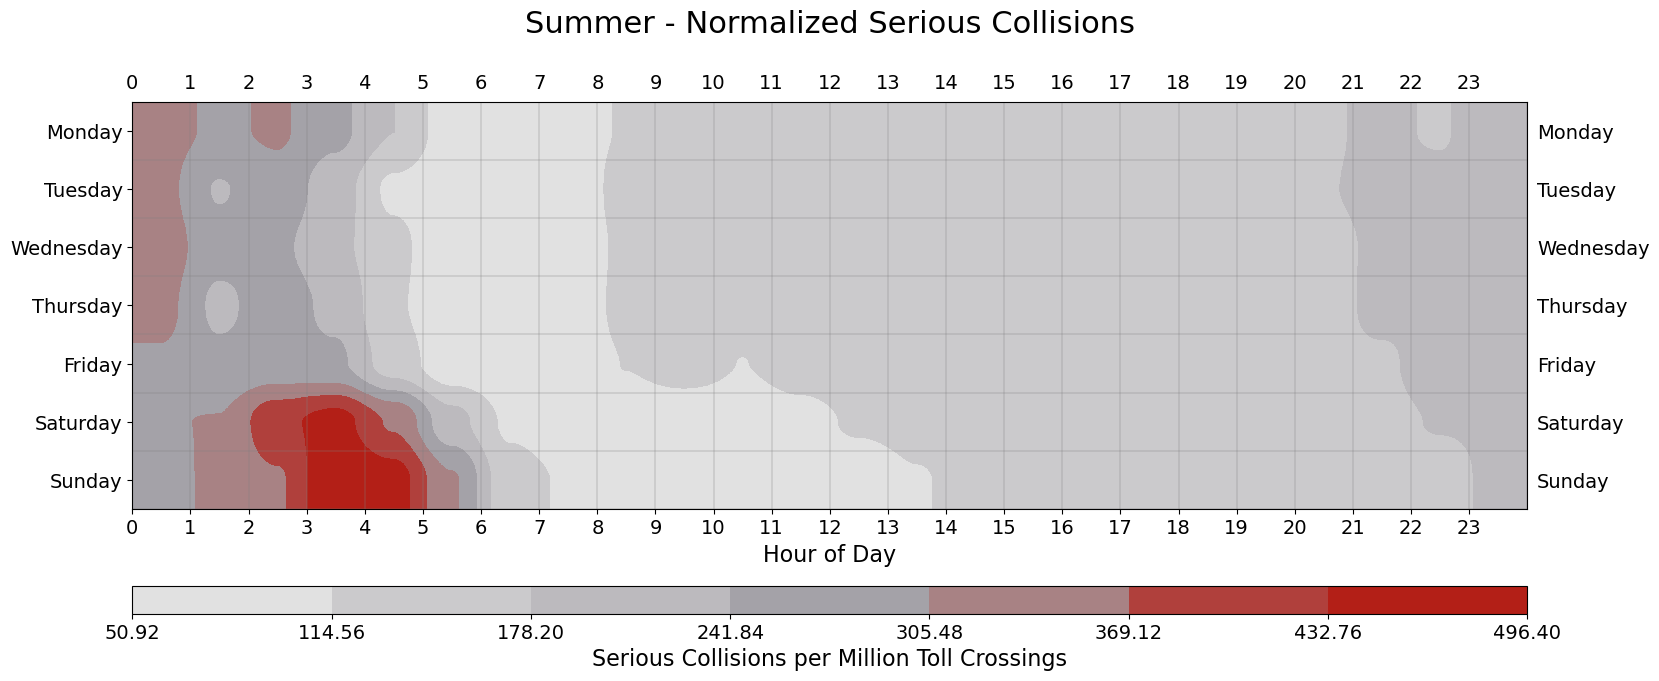

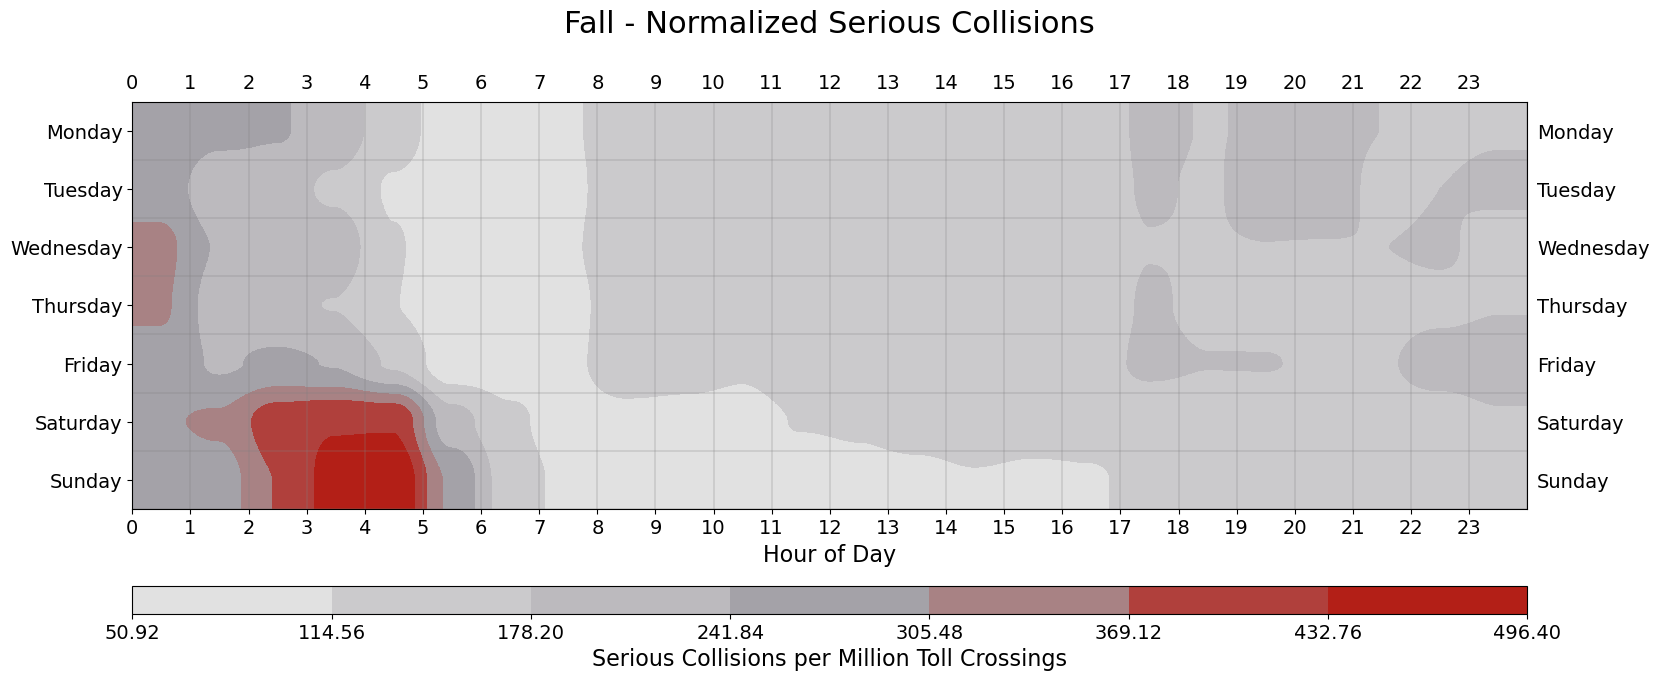

In [39]:
mn_mx_serious_norm = get_normalized_crosstab_min_max(
    serious_ex_2017,
    mta_crossings,
    "season",
    SEASONS,
    aggfunc_norm="sum",
    agg_col="Sum Vehicles",
    norm_divisor=MILLION,
)

for season in SEASONS:
    season_df = serious_ex_2017[serious_ex_2017["season"] == season]
    season_ct = src.utils.make_week_crosstab(
        season_df, 1, day_of_week_map=DAY_OF_WEEK_MAP
    )

    crossing_df = mta_crossings[mta_crossings["season"] == season]
    crossing_ct = src.utils.make_week_crosstab(
        crossing_df,
        MILLION,
        aggfunc="sum",
        values=crossing_df["Sum Vehicles"],
        day_of_week_map=DAY_OF_WEEK_MAP,
    )

    norm_ct = season_ct / crossing_ct

    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Normalized Serious Collisions",
        cbar_label="Serious Collisions per Million Toll Crossings",
    )
    viz.make_heat_map(
        norm_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_serious_norm,
        save=os.path.join(IMG_DIR, "trends", season.lower() + "_heat_norm.png"),
    )

## Weekly Collisions with Pedestrians and Cyclists Through the Seasons

Pedestrian and cyclist injuries and deaths are particularly concentrated in the fall

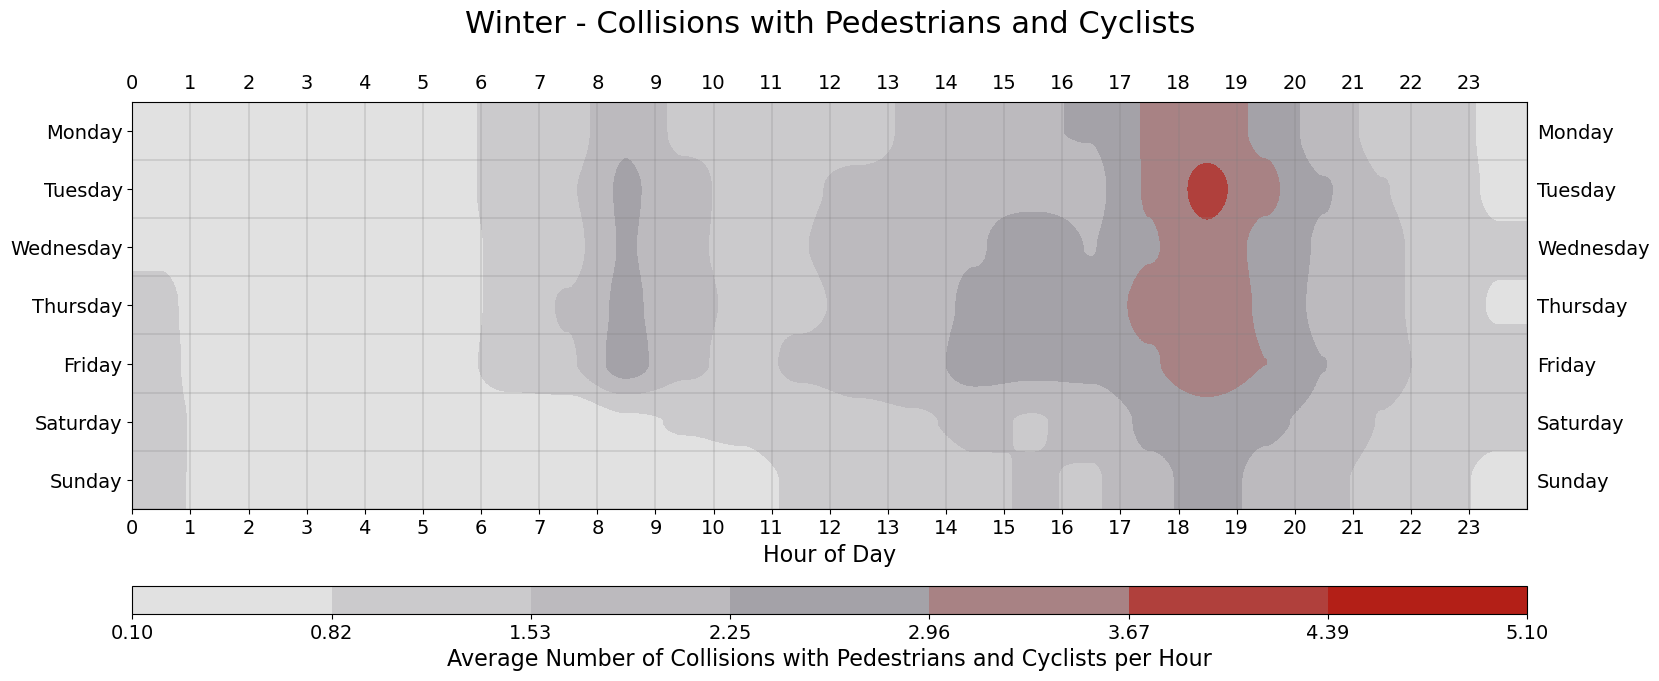

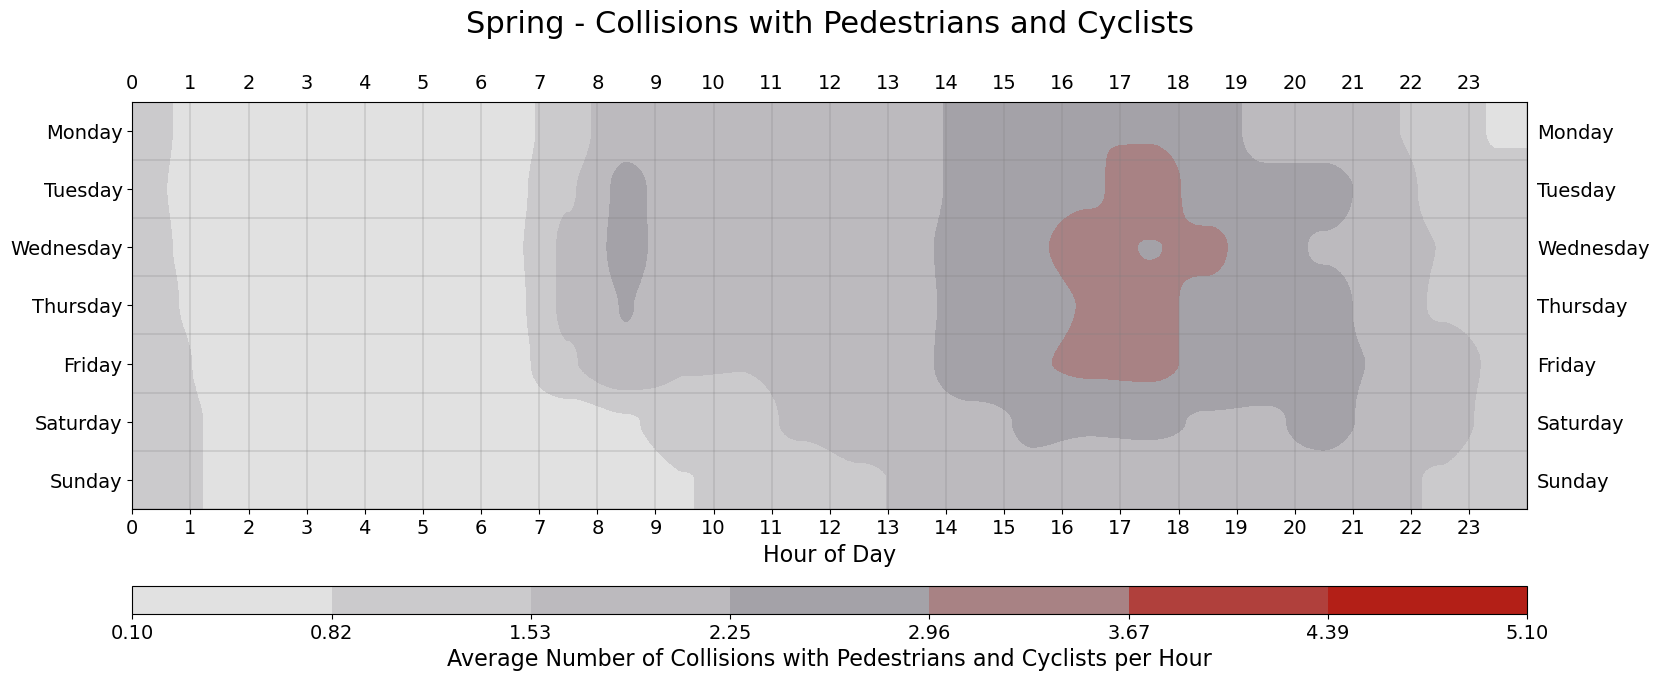

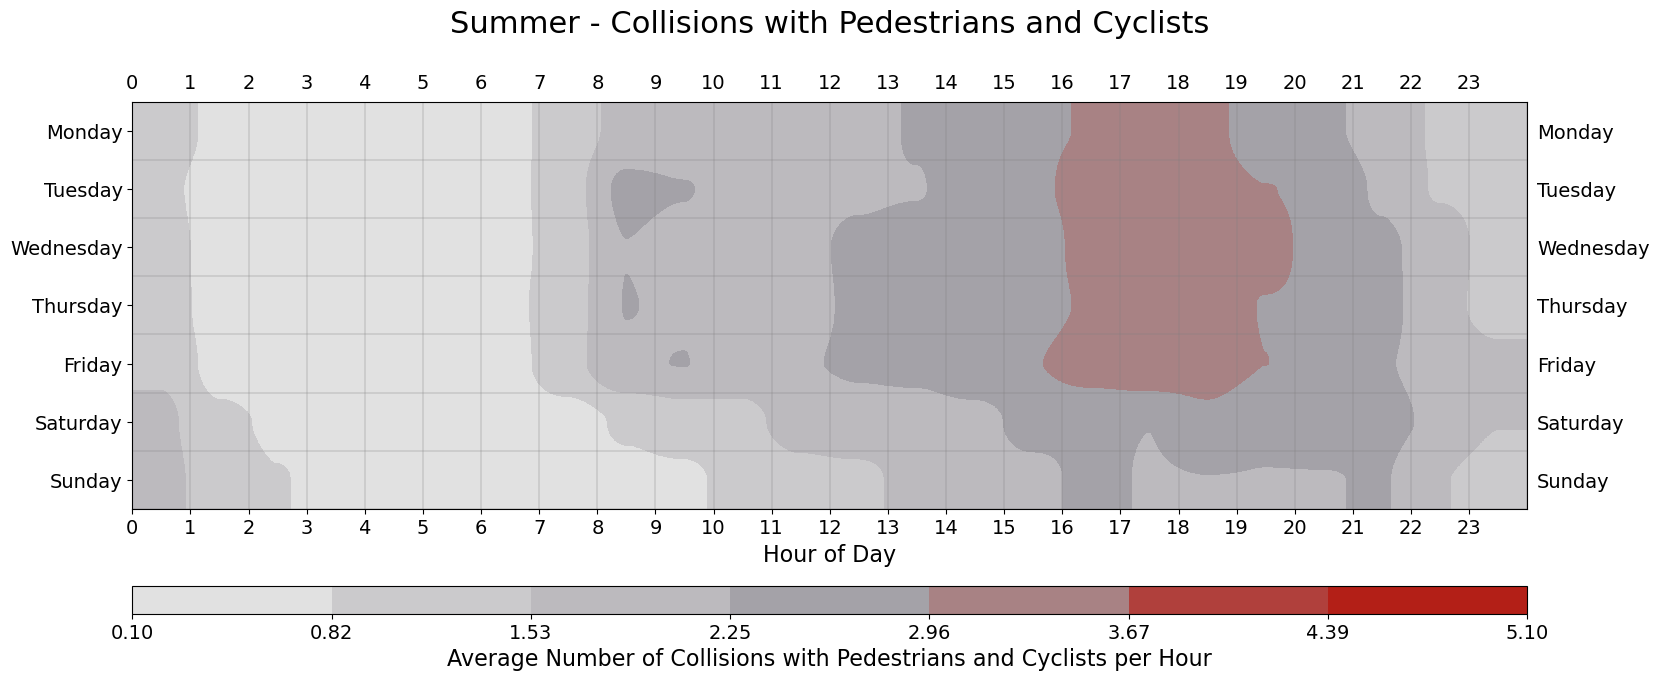

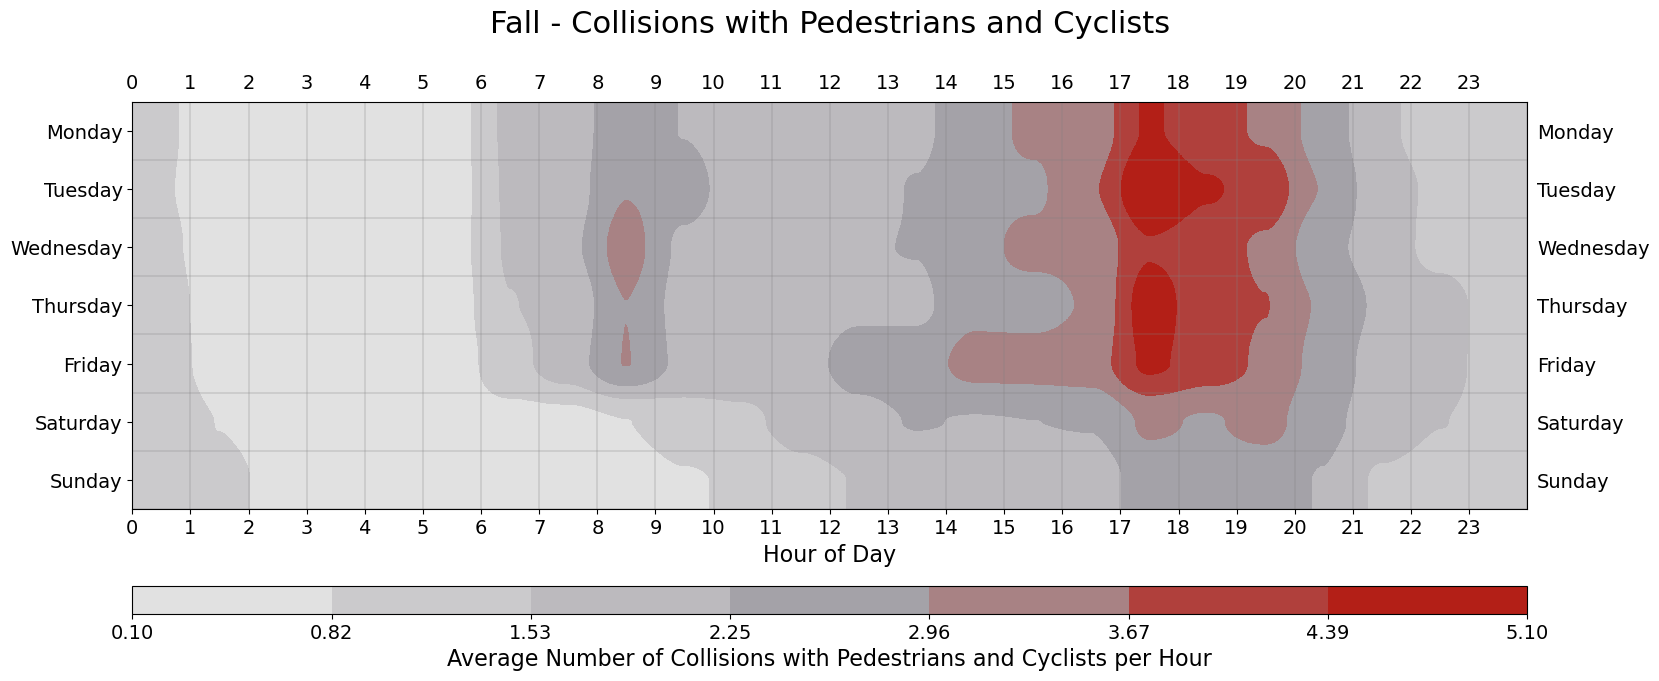

In [40]:
mn_mx_non_motorist = src.utils.get_crosstab_min_max(
    non_motorist, "season", SEASONS, divisor=(total_weeks / 4)
)
for season in SEASONS:
    season_df = non_motorist[non_motorist["season"] == season]
    season_ct = src.utils.make_week_crosstab(
        season_df, (total_weeks / 4), day_of_week_map=DAY_OF_WEEK_MAP
    )
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Collisions with Pedestrians and Cyclists",
        cbar_label="Average Number of Collisions with Pedestrians and Cyclists per Hour",
    )
    viz.make_heat_map(
        season_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_non_motorist,
        save=os.path.join(IMG_DIR, "trends", season.lower() + "_non_motor_heat.png"),
    )

## Normalized Weekly Collisions with Pedestrians and Cyclists Through the Seasons
- Collisions with pedestrians and cyclists (adjusting for vehicle activity) are notably elevated during the early morning hours in the summer and fall
- There seems to also be an elevated number of collisions in the afternoons during the fall

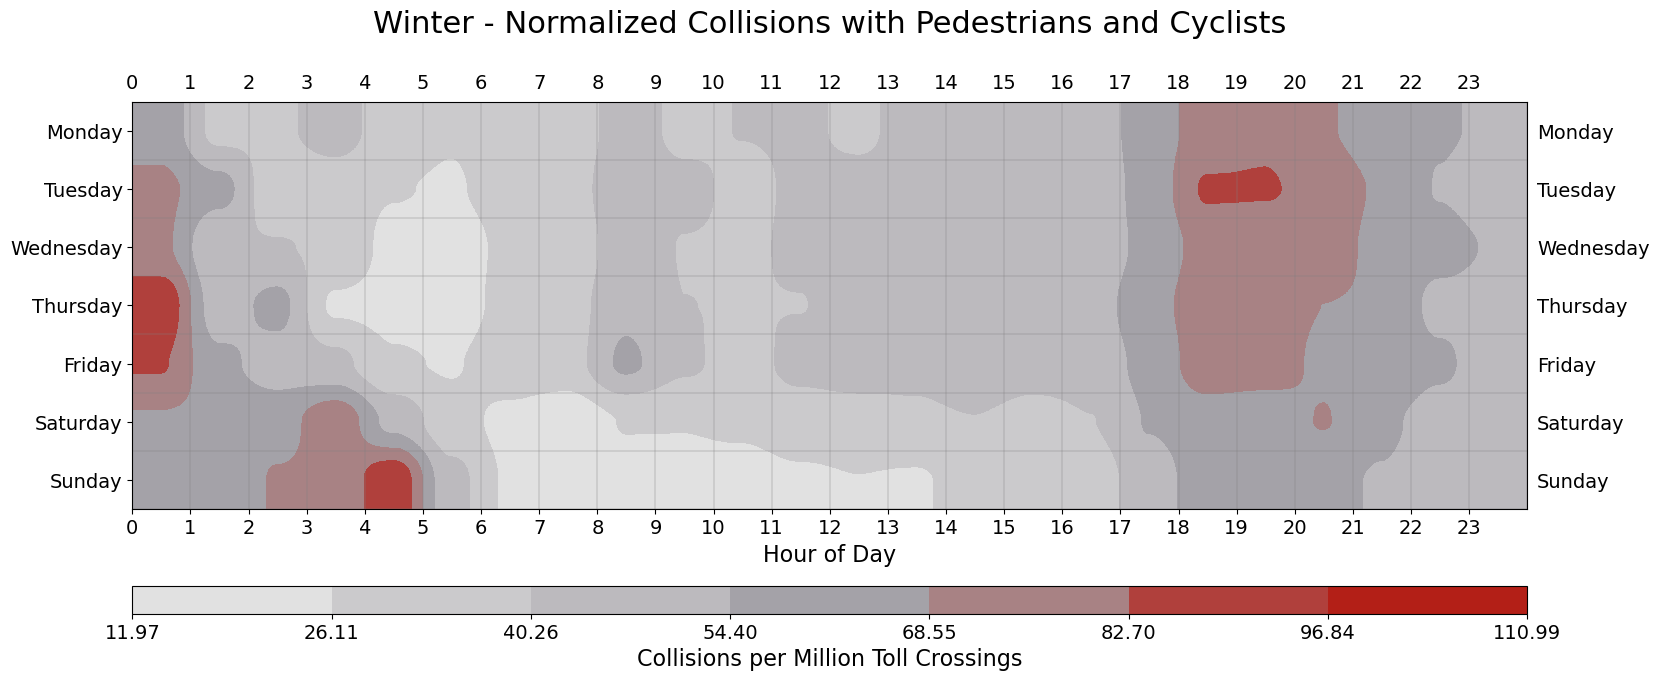

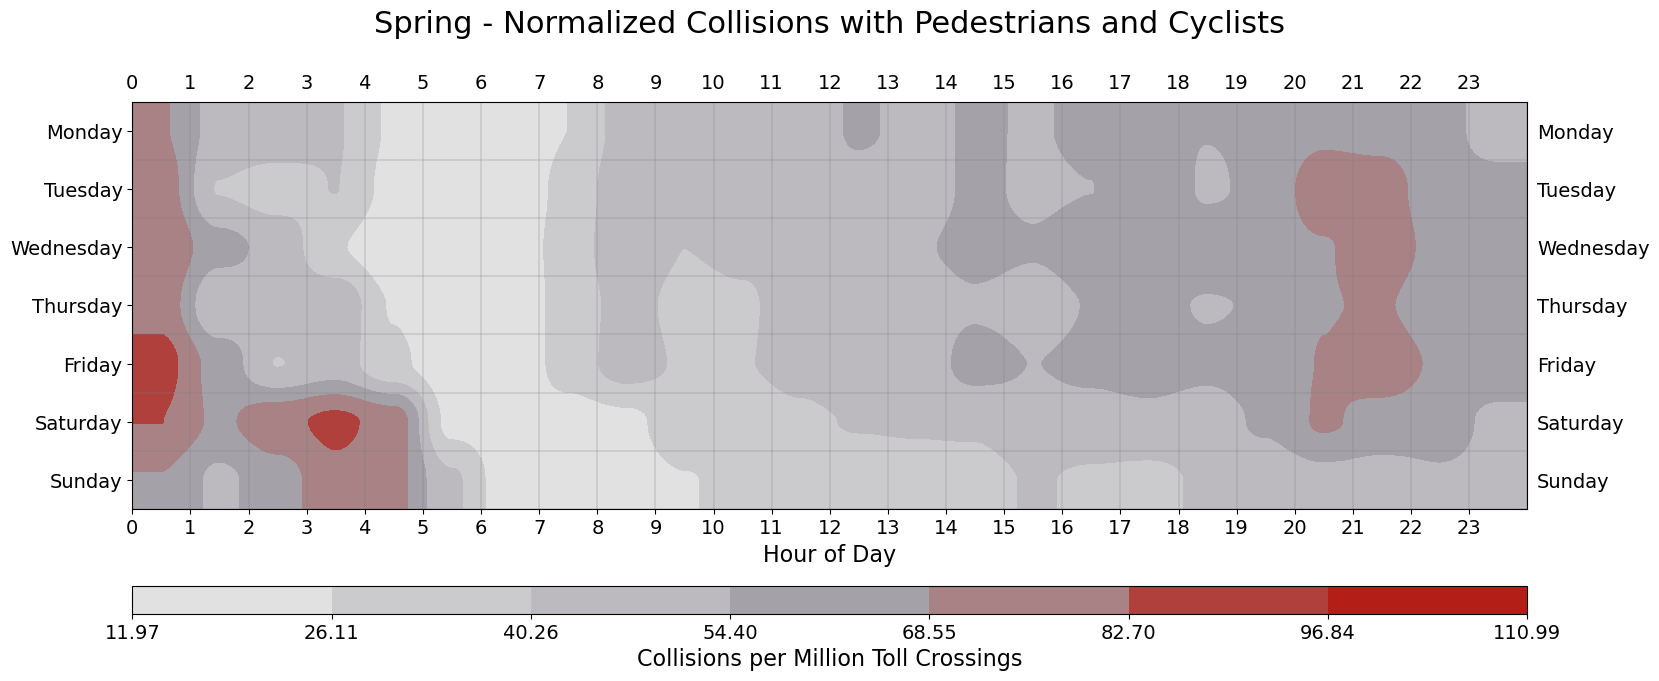

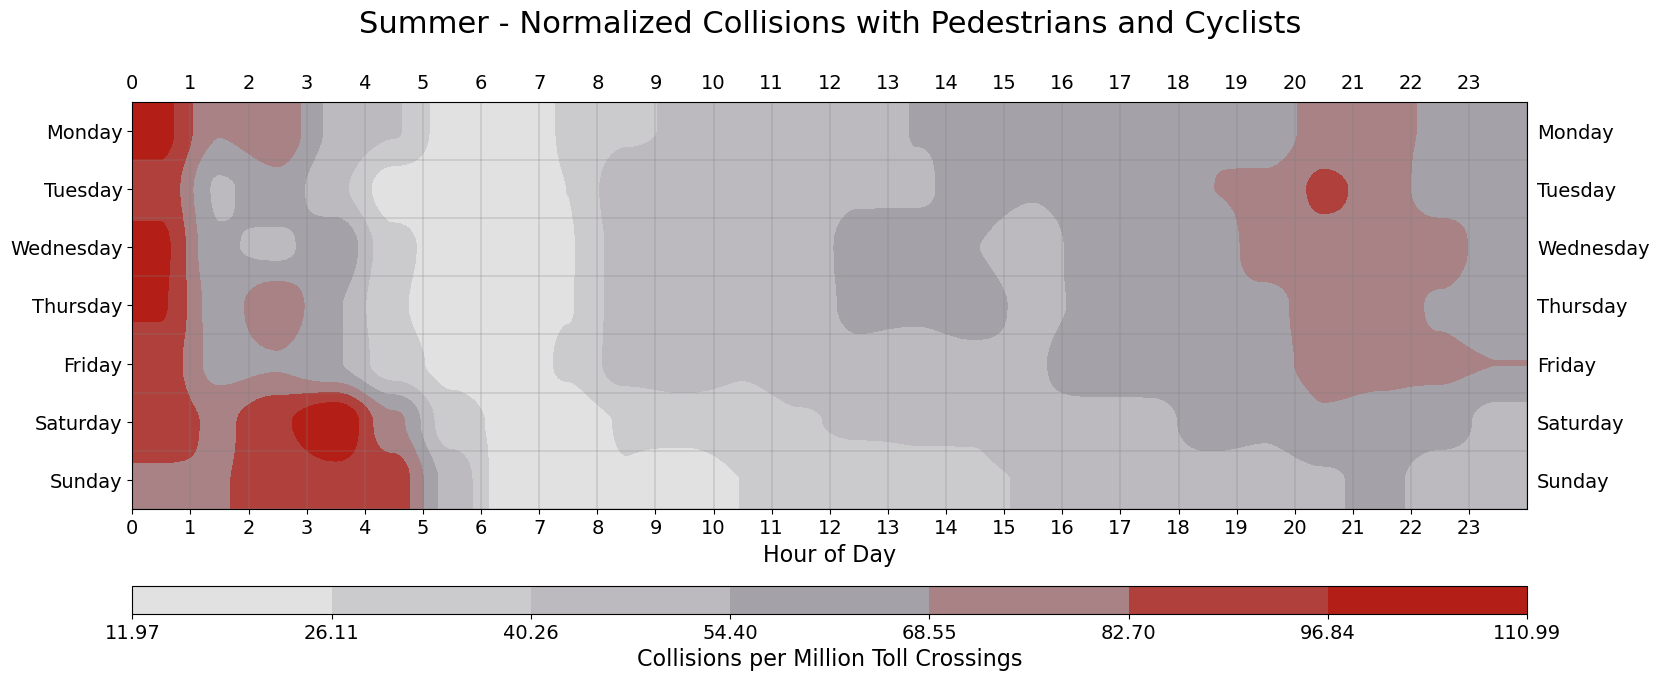

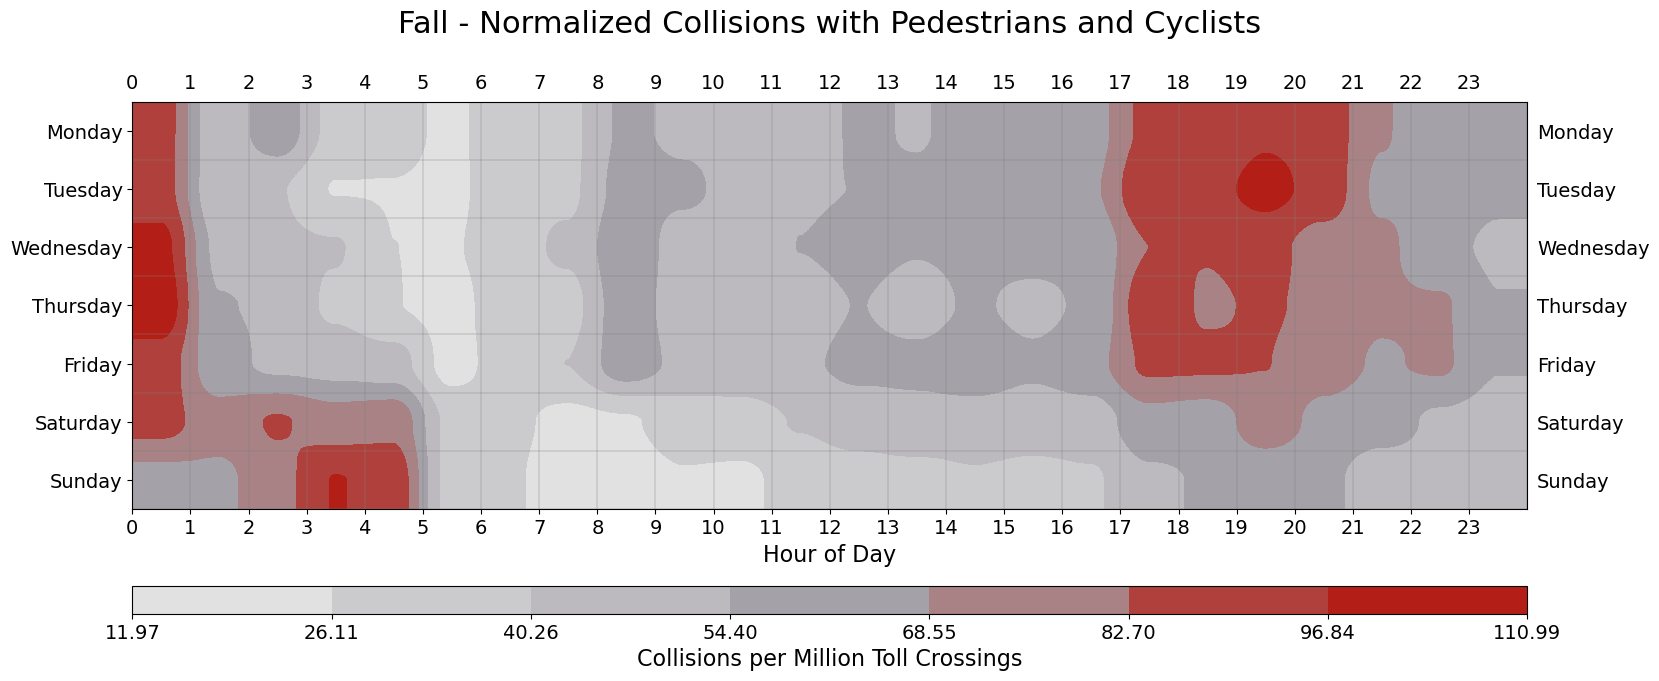

In [41]:
mn_mx_non_motorist_norm = get_normalized_crosstab_min_max(
    non_motorist_ex_2017,
    mta_crossings,
    "season",
    SEASONS,
    aggfunc_norm="sum",
    agg_col="Sum Vehicles",
    norm_divisor=MILLION,
)

for season in SEASONS:
    season_df = non_motorist_ex_2017[non_motorist_ex_2017["season"] == season]
    season_ct = src.utils.make_week_crosstab(
        season_df, 1, day_of_week_map=DAY_OF_WEEK_MAP
    )

    crossing_df = mta_crossings[mta_crossings["season"] == season]
    crossing_ct = src.utils.make_week_crosstab(
        crossing_df,
        MILLION,
        aggfunc="sum",
        values=crossing_df["Sum Vehicles"],
        day_of_week_map=DAY_OF_WEEK_MAP,
    )

    norm_ct = season_ct / crossing_ct

    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Normalized Collisions with Pedestrians and Cyclists",
        cbar_label="Collisions per Million Toll Crossings",
    )
    viz.make_heat_map(
        norm_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_non_motorist_norm,
        save=os.path.join(
            IMG_DIR, "trends", season.lower() + "_non_motor_heat_norm.png"
        ),
    )

# Conclusions

- From 2013-2019, serious collisions trended upwards and collisions involving pedestrians or cyclists were approximately flat
- These collisions dropped dramatically in 2020 but have been trending upwards
- Collisions normalized by vehicle activity (measured by MTA toll crossings) appears to be trending downwards from 2018
- Collisions (both categories) are elevated from May through October
- September and October seem to be particularly bad months for pedestrian and cyclist injuries and deaths
- Fridays have the most collisions (both categories) and Sundays have the fewest
- Collisions (both categories) peak weekday afternoons to early evening
- The weekday morning commute is a secondary cluster of collisions (both categories)
- An elevated number of collisions occur on Saturday and Sunday mornings from midnight to 6am, with a spike in deaths between 4am and 5am


# Follow-Up Questions
- Why are normalized collisions elevated in the fall? 
- Why does October appear to be a particularly bad month for pedestrians and cyclists?
- What causes the increase in collisions on Friday afternoons and evenings?
- Is intoxication the root cause of spike in deaths from 4am to 5am Saturday and Sunday morning? Are there other contributing factors?